# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
# dir_github = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()
dir_github = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone/Mothership_Zeta/MZ/tracking').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [6]:
# from basic_neural_processing_modules import plotting_helpers, image_processing

In [7]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

In [8]:
%matplotlib notebook

# Import paths

In [9]:
dir_allOuterFolders = Path(r"/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1").resolve()
# dir_allOuterFolders = Path(r"/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_4_experiments/mouse_11_5/scanimage_data").resolve()
# dir_allOuterFolders = Path(r"/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage").resolve()

In [10]:
folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy'
# pathSuffixToOps = 'scanimage_data/exp/jobNum_0/suite2p/plane0/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

dir_StatFolders, dir_OpsFolders = [], []

for s2p_path in dir_allOuterFolders.rglob('*'):
    if "stat.npy" in str(s2p_path):
        dir_StatFolders.append(s2p_path)
    elif "ops.npy" in str(s2p_path):
        dir_OpsFolders.append(s2p_path)
                
dir_StatFolders = natsort.natsorted(dir_StatFolders)
dir_OpsFolders = natsort.natsorted(dir_OpsFolders)


# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
paths_allStat = np.array(dir_StatFolders)[:]
paths_allOps  = np.array(dir_OpsFolders)[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['20221010', '20221011', '20221012', '20221013', '20221014', '20221015', '20221016']
paths to all stat files: 
[PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221010/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/post/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221012/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221012/scanimage_data/exp/jobNum_0/suite2p/pl

In [11]:
# paths_allStat = np.delete(paths_allStat, -1)
# paths_allOps = np.delete(paths_allOps, -1)
# folders_allSessions = np.delete(folders_allSessions, -1)

In [ ]:
# paths_allStat[0] = Path(r"/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/stat.npy").resolve()
# paths_allOps[0] = Path(r"/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/ops.npy").resolve()

In [12]:
# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')

folder names of all sessions: 
['20221020' '20221021' '20221022' '20221023' '20221024' '20221025'
 '20221026' '20221028' '20221029' '20221030' '20221031' '20221101'
 '20221102' '20221103' '20221104']
paths to all stat files: 
[PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B/20221020/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B/20221021/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B/20221022/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B/20221023/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B/20221024/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy')
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_

In [11]:
toc['import_paths'] = time.time() - tic

# Import data

In [12]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.0,
    new_or_old_suite2p='new',
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36,36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=1);

Starting: Importing spatial footprints from stat files
Completed: Imported 15 stat files into class as self.statFiles. Total number of ROIs: 44023. Number of ROI from each file: [2310, 2670, 3146, 3138, 2108, 3179, 2296, 3679, 2267, 3555, 2638, 3381, 2442, 3613, 3601]


15it [00:03,  4.99it/s]


Converted 15 spatial footprint files into small centered images in self.ROI_images.
Imported 15 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.


100%|██████████| 15/15 [02:06<00:00,  8.41s/it]

Imported 15 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


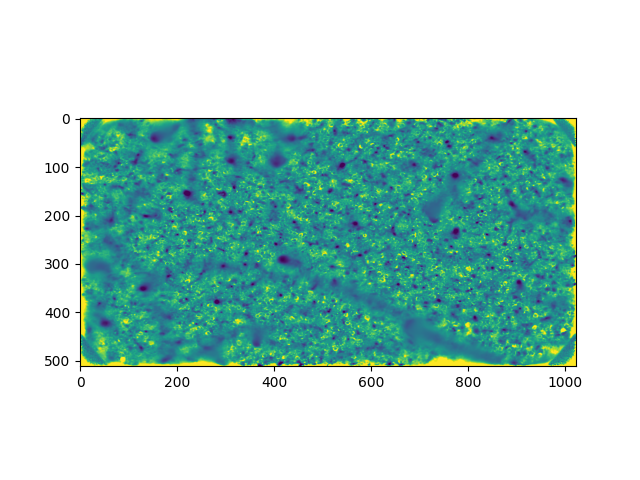

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


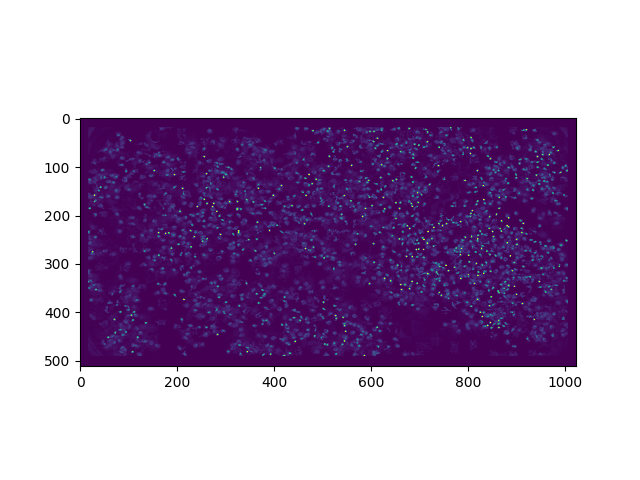

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


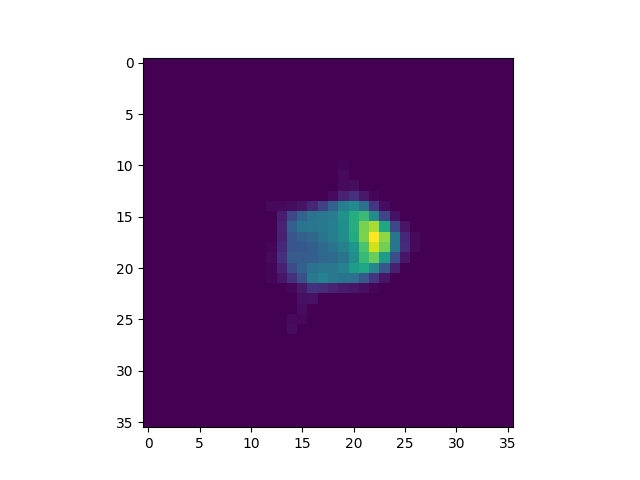

interactive(children=(IntSlider(value=0, description='i_frame', max=44022), Output()), _dom_classes=('widget-i…

In [13]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [15]:
toc['import_data'] = time.time() - tic

# Alignment

In [16]:
use_CLAHE = False
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if use_CLAHE else data.FOV_images

pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
#     im_template=FOV_images[idx_st],
    template=FOV_images[idx_st],
    ims_moving=FOV_images,
    template_method = "image"
);

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
#     templateFOV=pcr.ims_registered[idx_st],
    template=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


Registering ROIs...


100%|██████████| 15/15 [09:27<00:00, 37.80s/it]


<IPython.core.display.Javascript object>


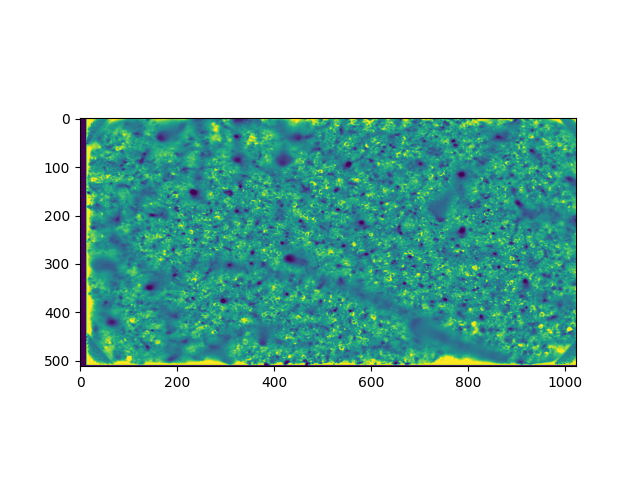

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


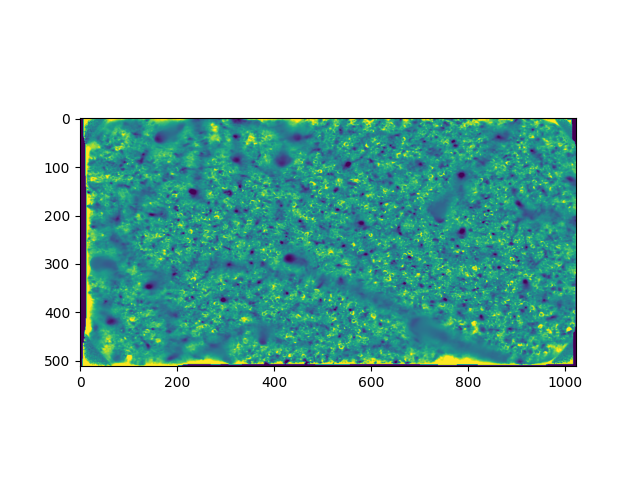

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


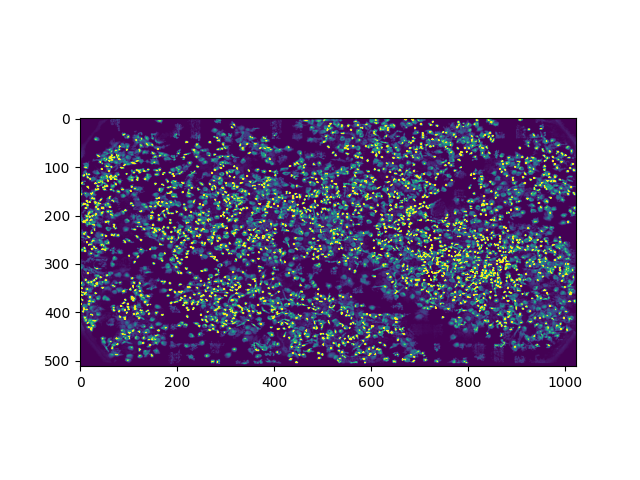

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


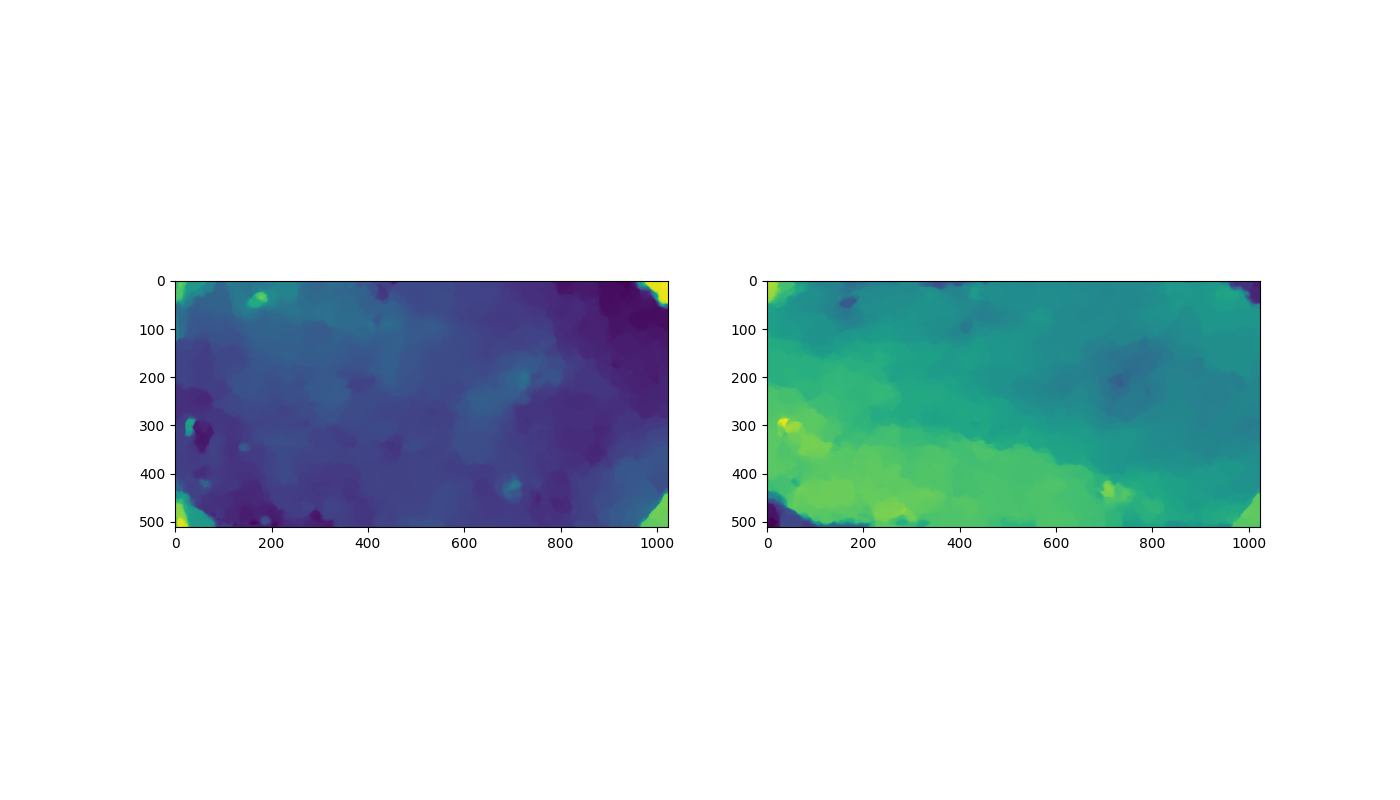

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

In [17]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

In [18]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [19]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


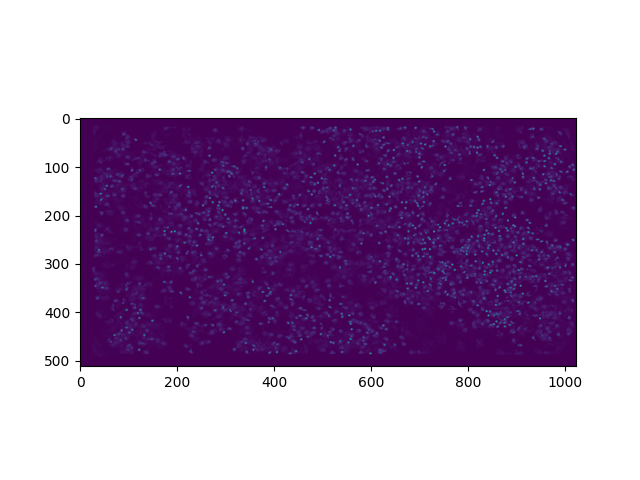

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

In [20]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [22]:
toc['blur'] = time.time() - tic

## Neural network embedding distances

In [23]:
# data.um_per_pixel = 2.0

In [24]:
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=1, # default:8
    pinMemory_dataloader=False, # default: True
#     numWorkers_dataloader=mp.cpu_count(),
    numWorkers_dataloader=0,
    persistentWorkers_dataloader=False, # default: True
#     prefetchFactor_dataloader=2,    # default: 2
);

Successful hash comparison. Found matching files: {'params': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/params.json', 'model': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/model.py', 'state_dict': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/model.py
Loaded params_model from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/params.json


/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


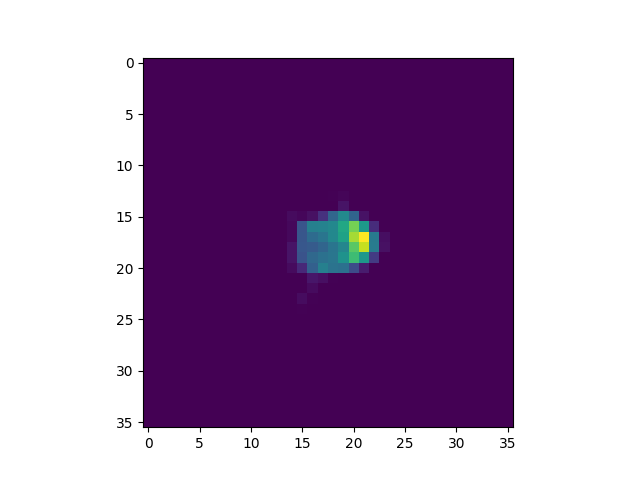

interactive(children=(IntSlider(value=0, description='i_frame', max=44022), Output()), _dom_classes=('widget-i…

In [25]:
%matplotlib notebook
visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [32]:
help(roinet)

Help on ROInet_embedder in module ROICaT.tracking.ROInet object:

class ROInet_embedder(builtins.object)
 |  ROInet_embedder(device='cpu', dir_networkFiles=None, download_from_gDrive='check_local_first', gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN', hash_dict_networkFiles={'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'), 'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'), 'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da')}, forward_pass_version='latent', verbose=True)
 |  
 |  Class for loading the ROInet model, preparing data for it, 
 |   and running it.
 |  
 |  RH 2022
 |  
 |  Methods defined here:
 |  
 |  __init__(self, device='cpu', dir_networkFiles=None, download_from_gDrive='check_local_first', gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN', hash_dict_networkFiles={'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'), 'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'), 'state_dict': ('ConvNext_tiny__1_0

In [27]:
help(roinet.dataloader)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: int = 2, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process 

In [28]:
roinet.generate_latents();


starting: running data through network


  0%|          | 0/44023 [00:00<?, ?it/s]/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|██████████| 44023/44023 [04:01<00:00, 182.63it/s]

completed: running data through network


In [29]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [30]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [31]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


441it [00:01, 324.30it/s]                 

Completed: SWT transform on ROIs


In [33]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [34]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


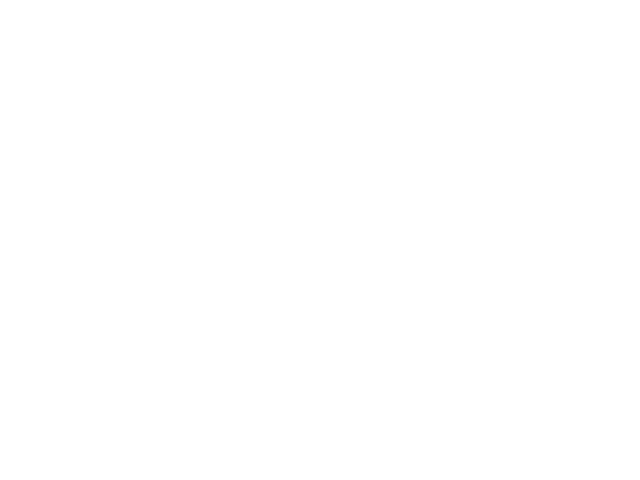

Computing pairwise similarity between ROIs...


100%|██████████| 32/32 [01:38<00:00,  3.06s/it]


Joining blocks into full similarity matrices...
Joining s_sf...


32it [00:00, 257.65it/s]


Joining s_NN...


32it [00:00, 84.84it/s] 


Joining s_SWT...


32it [00:00, 84.96it/s] 


Joining s_sesh...


32it [00:00, 77.65it/s]


In [35]:
sim = similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=0.8,
);

In [36]:
import scipy
def find_nan_in_csr(X):

    X = scipy.sparse.coo_matrix(X)
    for i, j, v in zip(X.row, X.col, X.data):
        if (np.isnan(v) or np.isinf(v)):
            print(i, j, v)
    return None

In [37]:
sim.make_normalized_similarities(
    centers_of_mass=data.get_midCoords(),
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|██████████| 44023/44023 [00:03<00:00, 14535.19it/s]


Normalizing SWT similarity scores...


100%|██████████| 44023/44023 [00:04<00:00, 9169.61it/s]


# Clustering

In [38]:
nan_SWT_z = scipy.sparse.csr_matrix(np.nan_to_num(sim.s_SWT_z.toarray(), nan=-1))

In [39]:
nan_SWT_z

<44023x44023 sparse matrix of type '<class 'numpy.float32'>'
	with 4362677 stored elements in Compressed Sparse Row format>

In [40]:
sim.s_SWT_z

<44023x44023 sparse matrix of type '<class 'numpy.float32'>'
	with 4362678 stored elements in Compressed Sparse Row format>

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.06704845279455185 with parameters {'power_SF': 1.6866590202469183, 'power_NN': 0.5536013865592826, 'power_SWT': 0.32327649932233177, 'p_norm': 0.8175561027219203, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.42528488180407553, 'b': 1.1760480614736595}, 'sig_SWT_kwargs': {'mu': 0.20907845380352832, 'b': 0.734633247836615}}


<IPython.core.display.Javascript object>


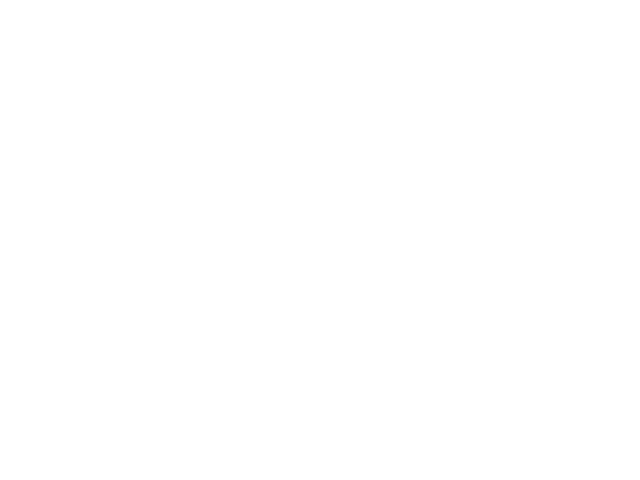

<IPython.core.display.Javascript object>


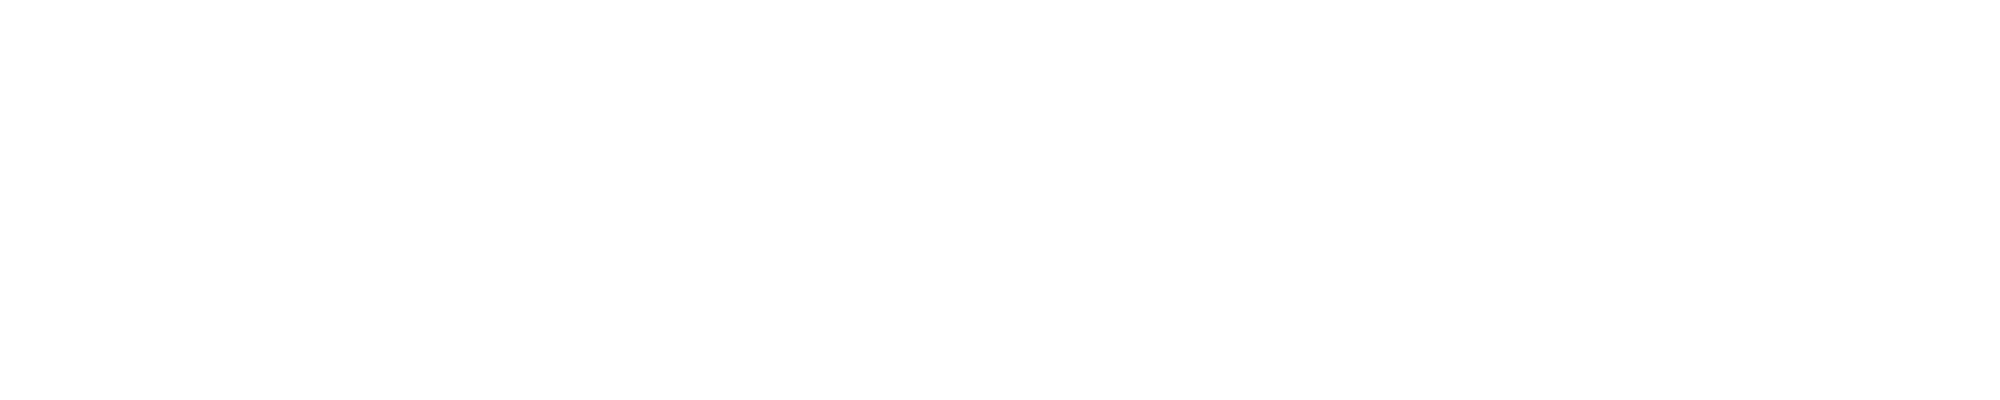

In [41]:
clusterer = clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
#     s_SWT_z=nan_SWT_z,
    s_sesh=sim.s_sesh,
    verbose=True
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

clusterer.make_pruned_similarity_graphs(
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

In [42]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=3,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.95,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


  0%|          | 0/3 [00:00<?, ?it/s]/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 3/3 [02:50<00:00, 56.93s/it]


In [43]:
## results_clustering
print(len(np.unique(labels)))
print((labels==-1).sum())

5626
9111


In [44]:
toc['clustering'] = time.time() - tic

# Visualize results

In [45]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


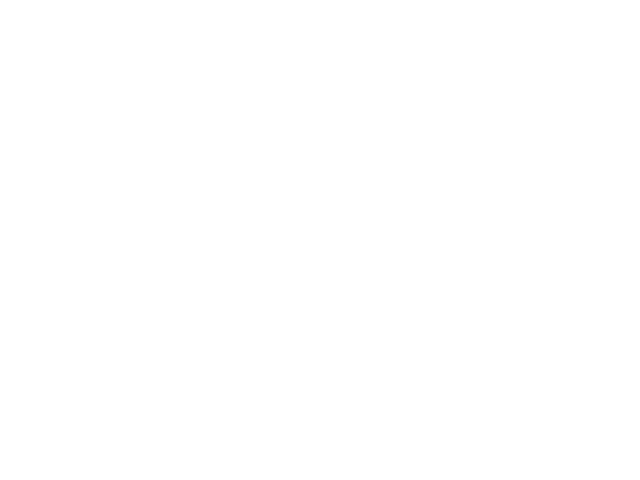

interactive(children=(IntSlider(value=0, description='i_frame', max=14), Output()), _dom_classes=('widget-inte…

In [46]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [47]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_183562/490205615.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


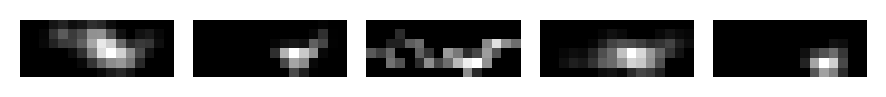

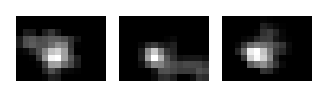

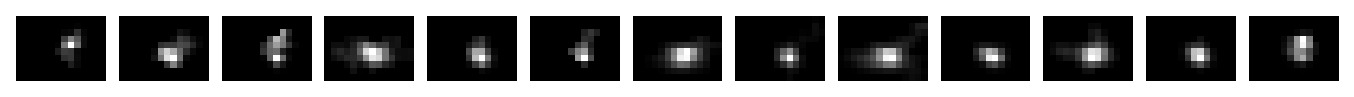

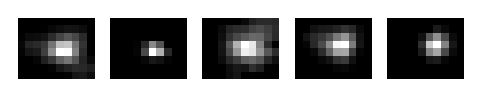

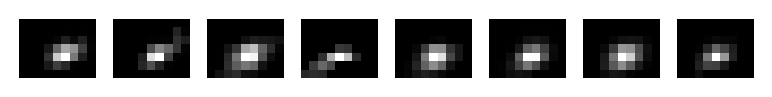

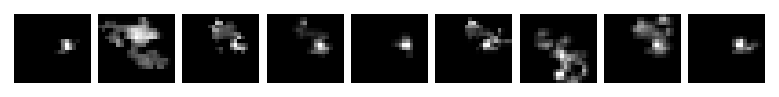

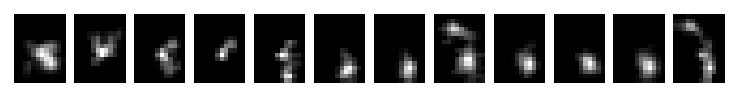

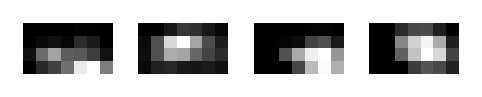

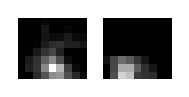

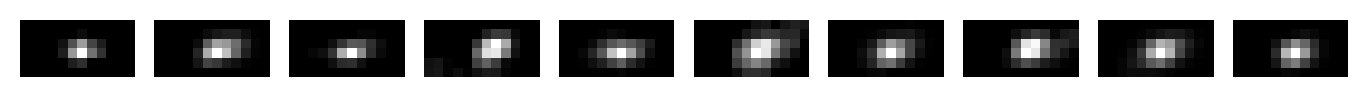

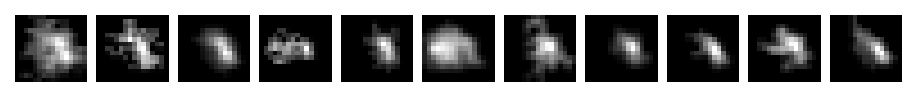

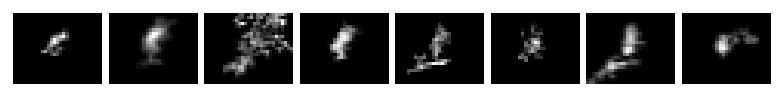

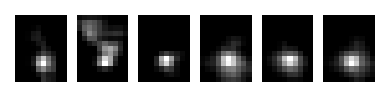

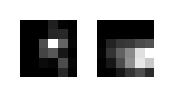

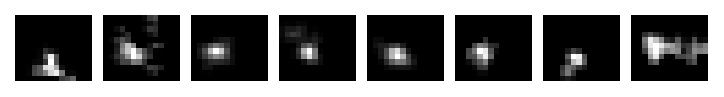

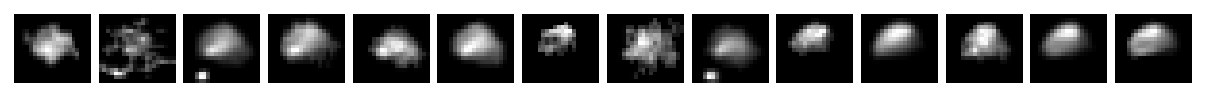

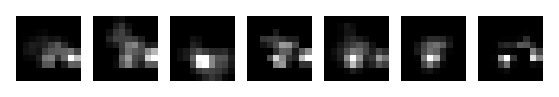

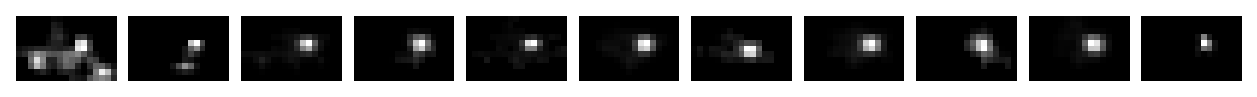

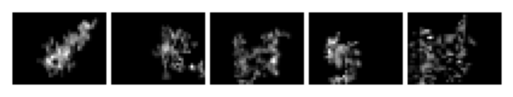

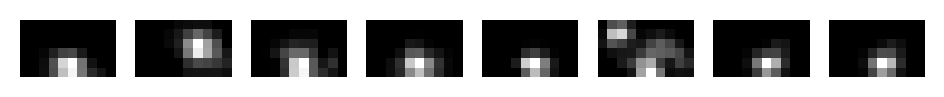

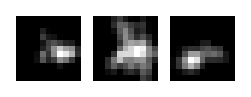

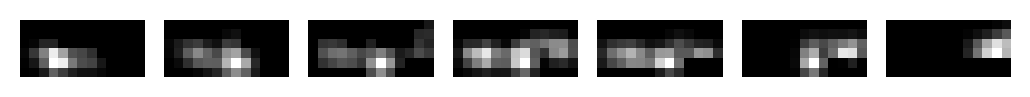

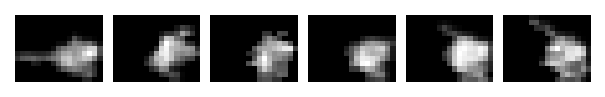

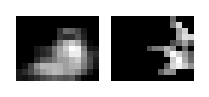

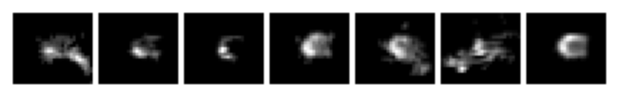

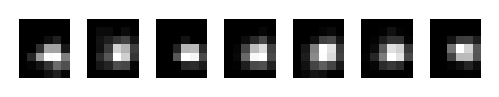

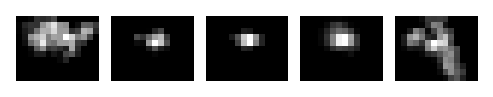

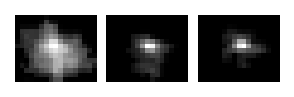

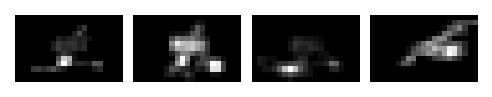

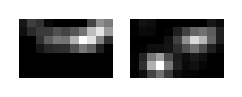

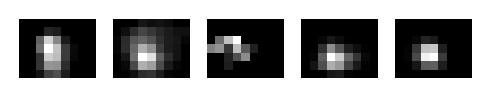

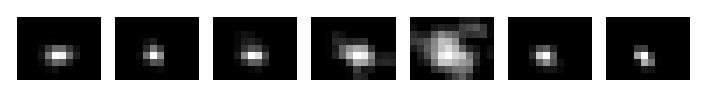

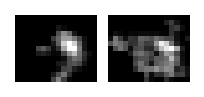

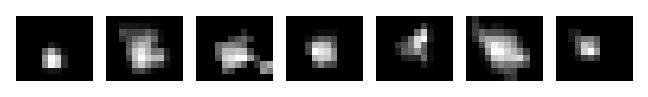

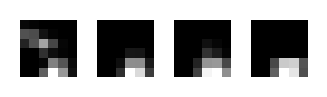

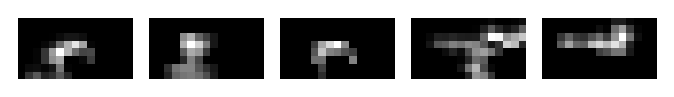

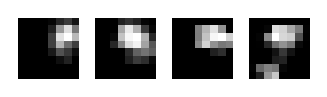

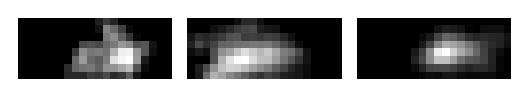

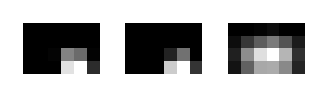

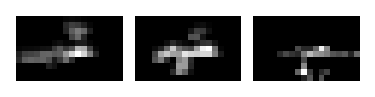

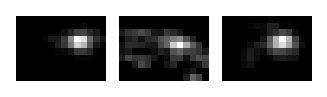

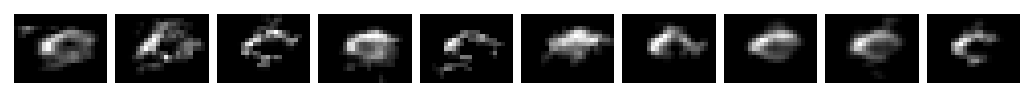

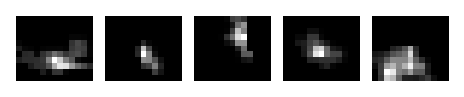

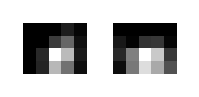

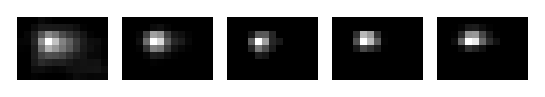

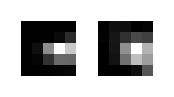

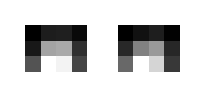

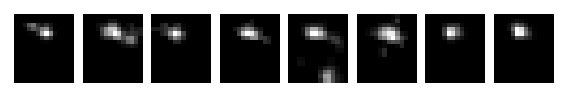

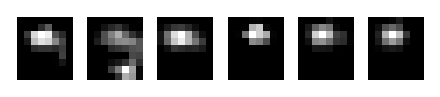

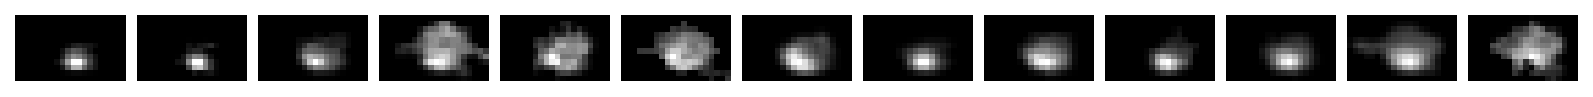

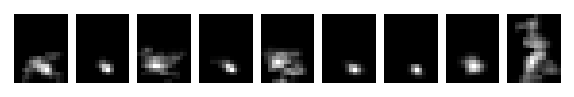

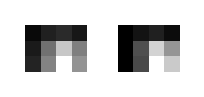

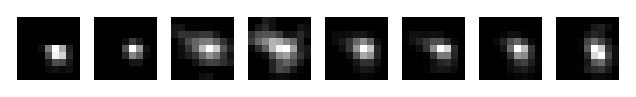

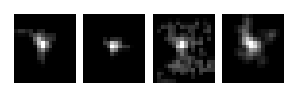

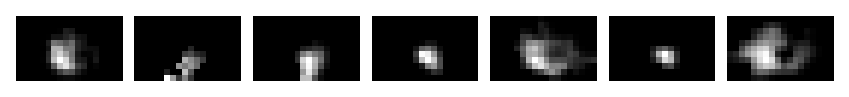

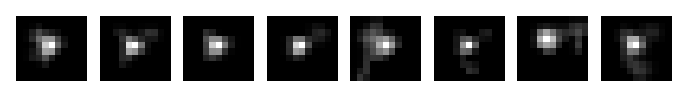

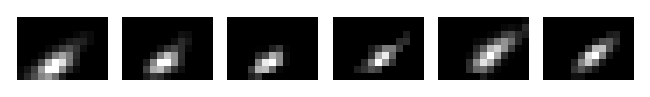

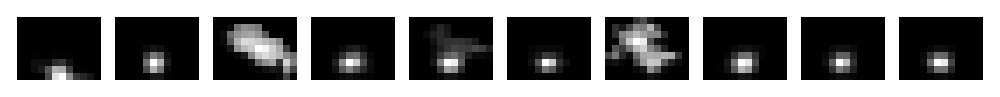

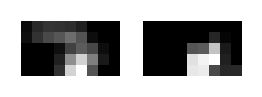

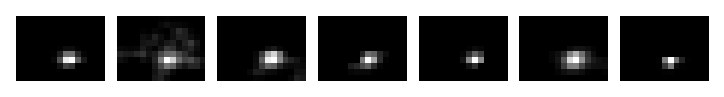

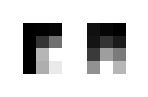

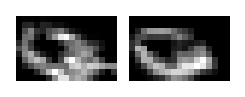

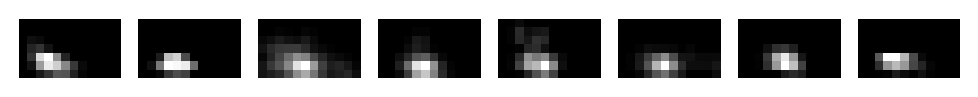

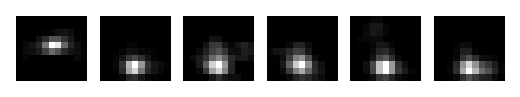

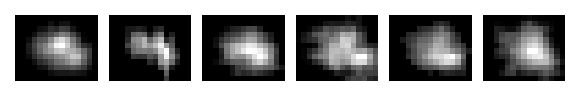

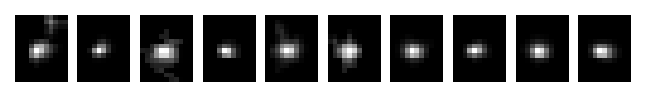

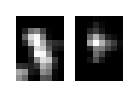

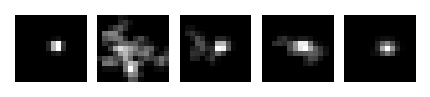

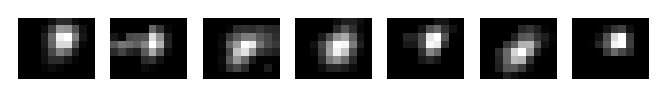

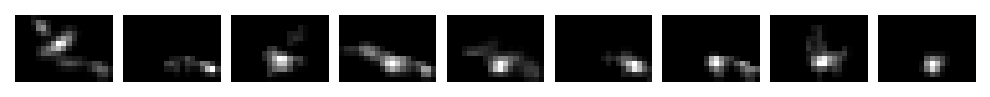

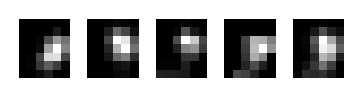

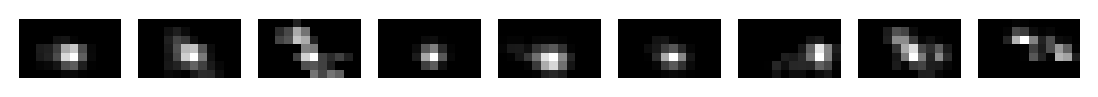

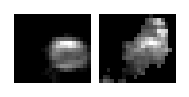

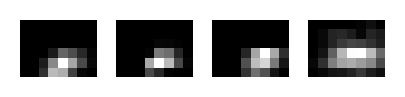

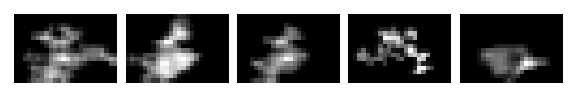

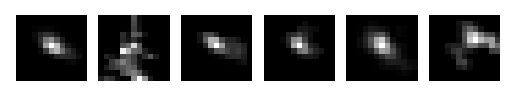

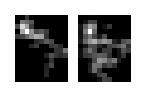

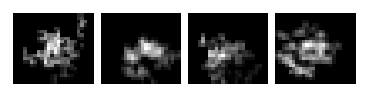

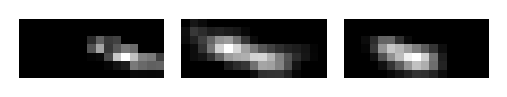

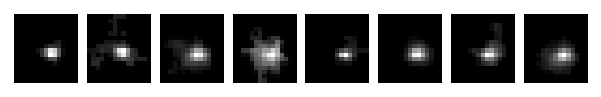

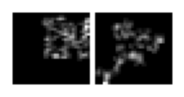

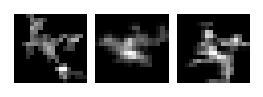

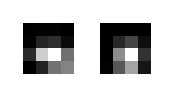

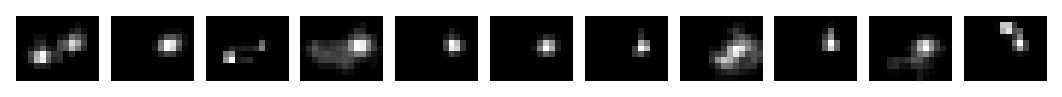

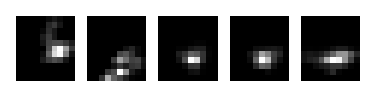

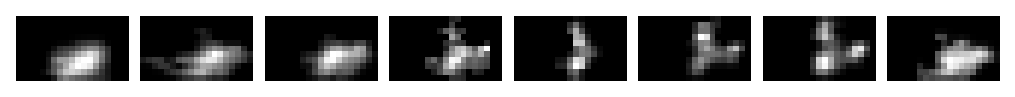

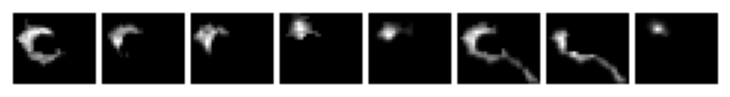

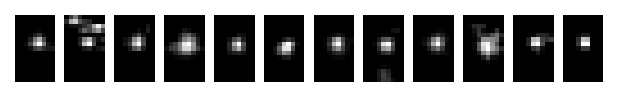

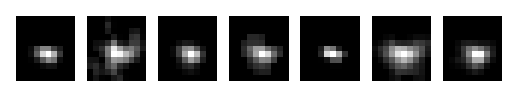

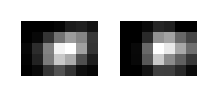

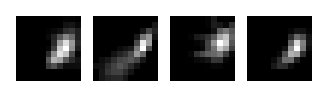

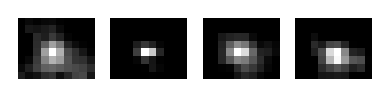

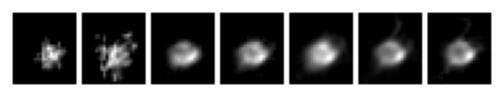

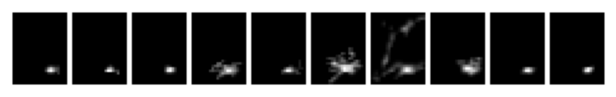

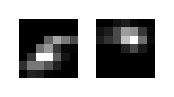

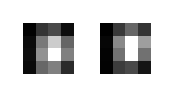

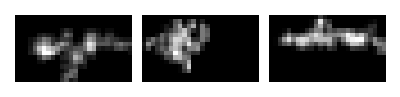

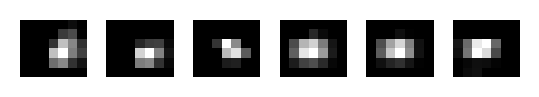

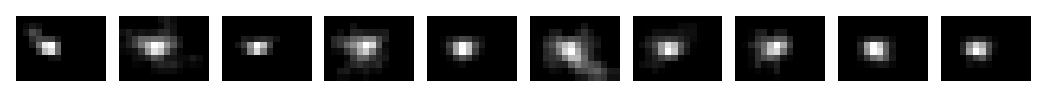

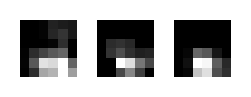

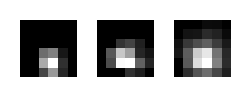

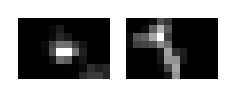

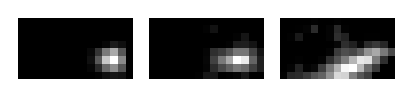

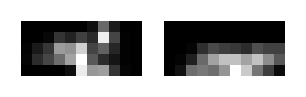

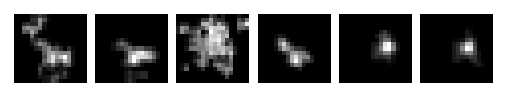

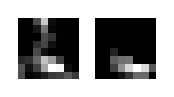

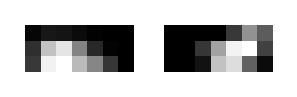

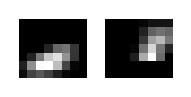

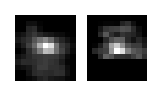

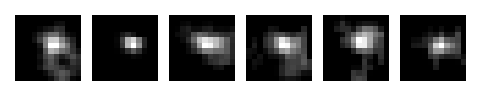

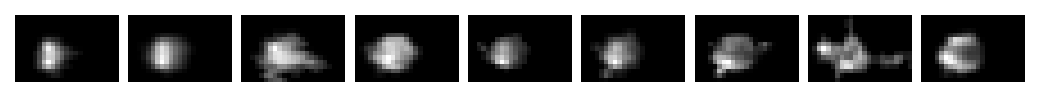

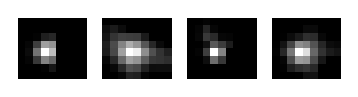

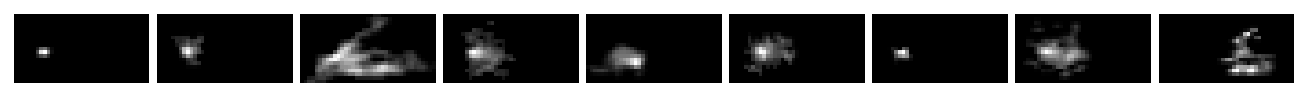

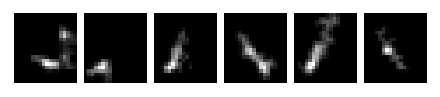

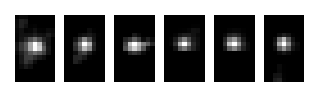

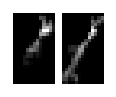

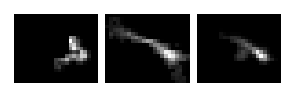

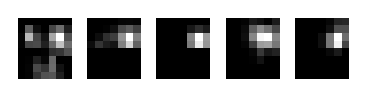

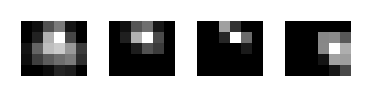

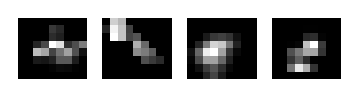

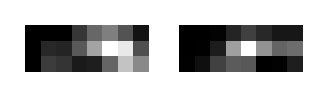

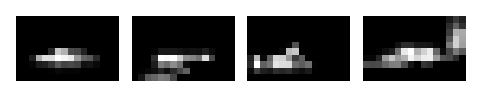

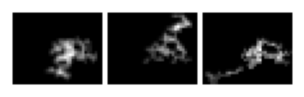

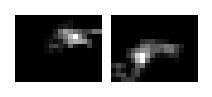

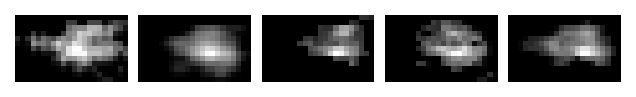

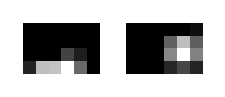

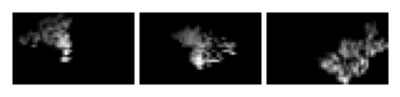

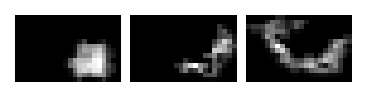

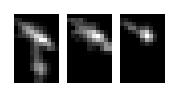

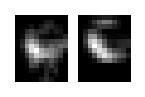

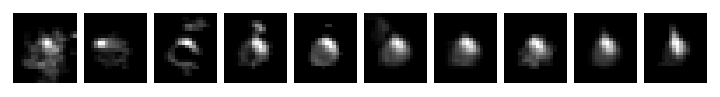

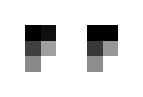

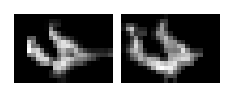

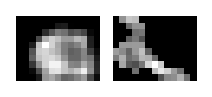

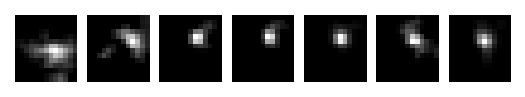

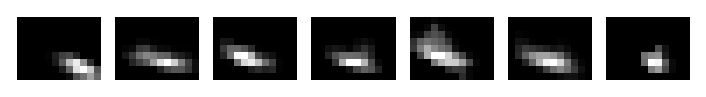

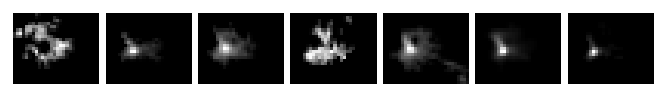

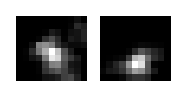

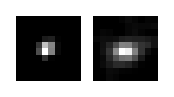

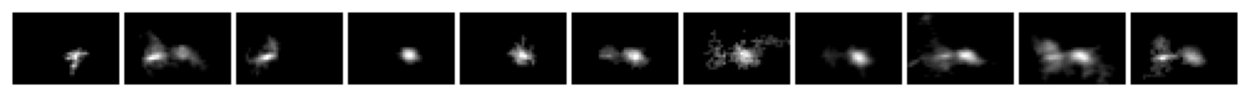

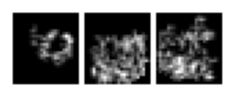

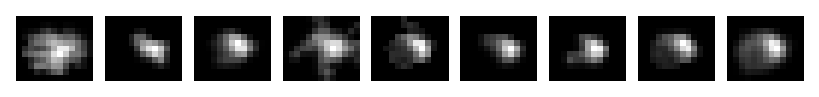

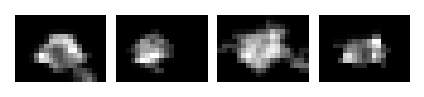

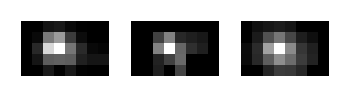

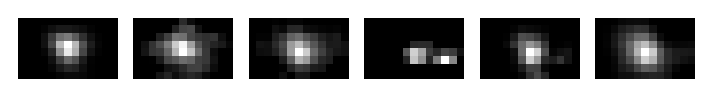

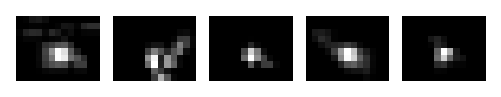

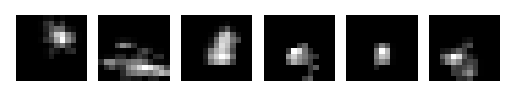

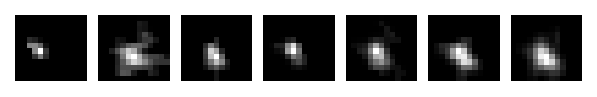

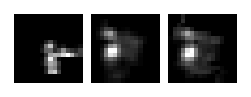

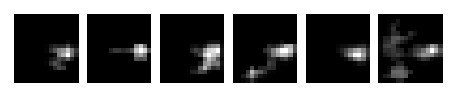

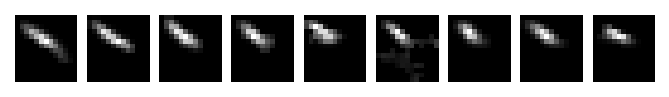

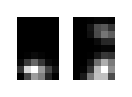

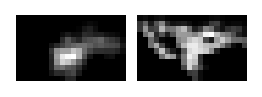

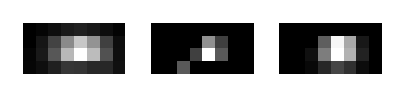

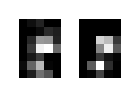

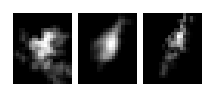

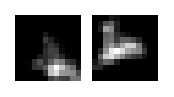

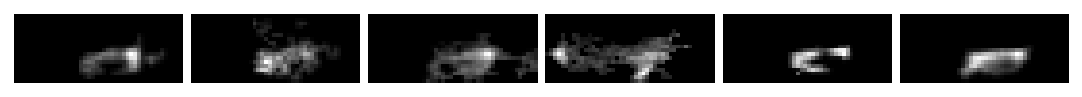

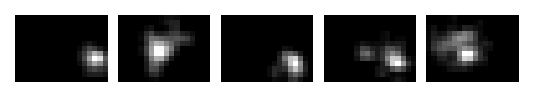

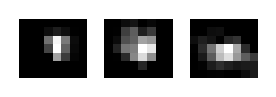

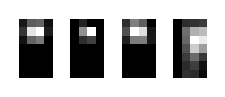

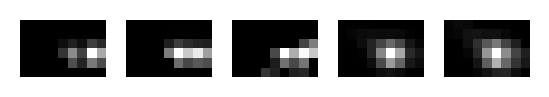

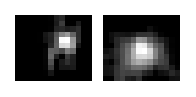

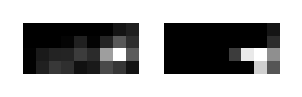

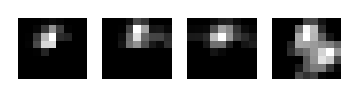

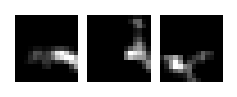

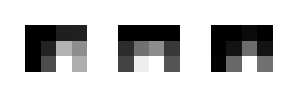

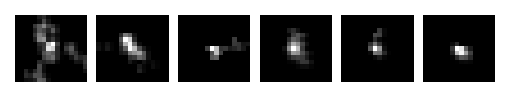

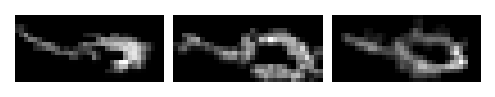

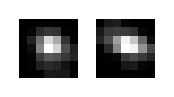

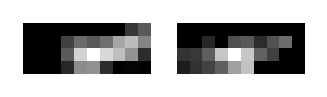

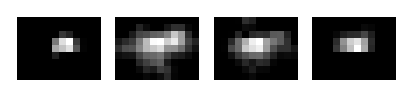

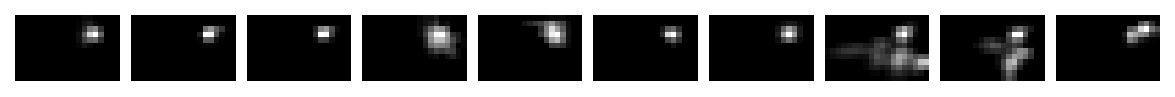

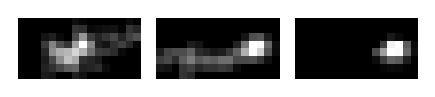

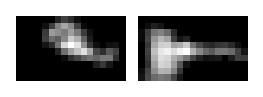

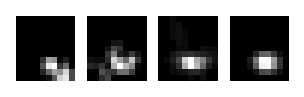

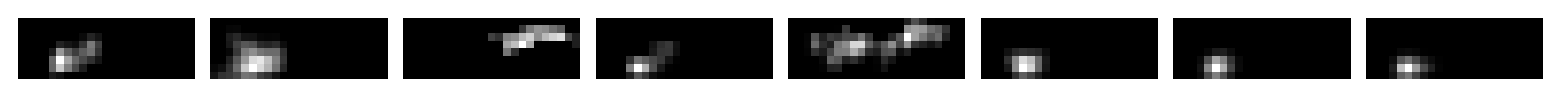

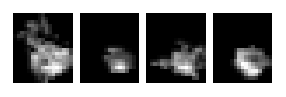

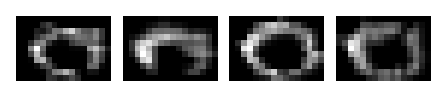

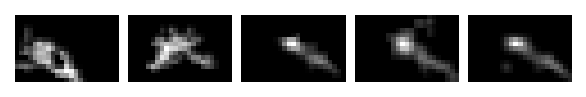

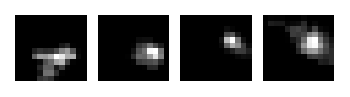

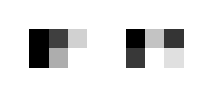

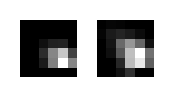

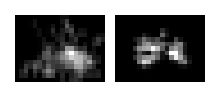

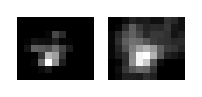

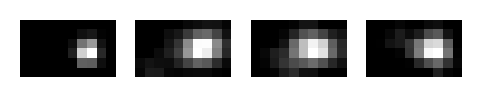

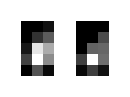

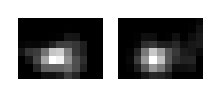

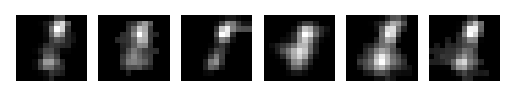

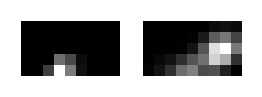

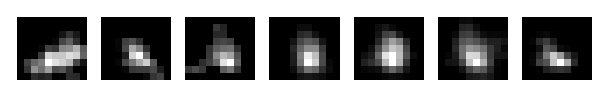

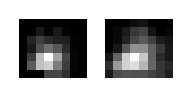

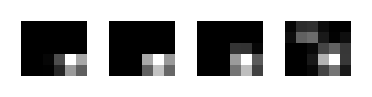

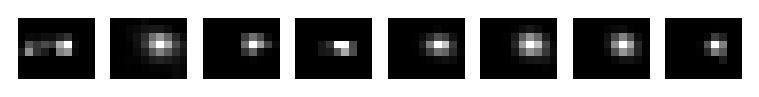

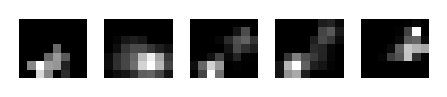

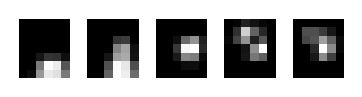

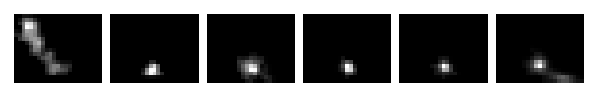

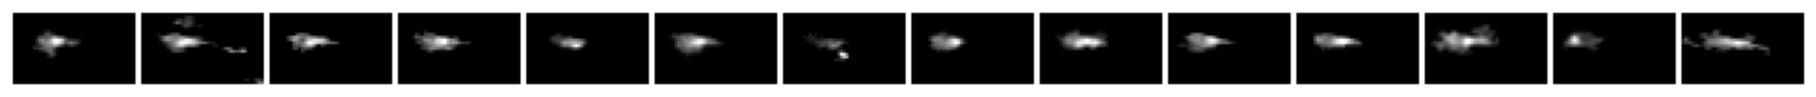

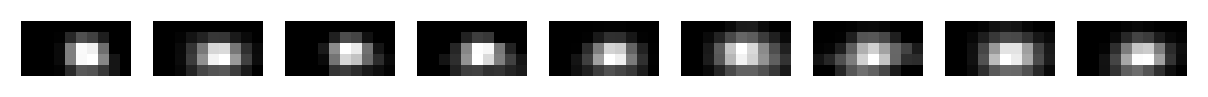

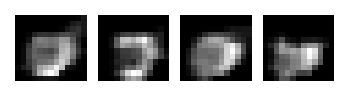

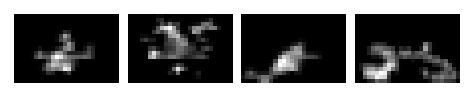

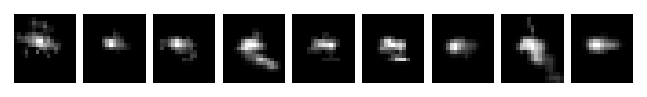

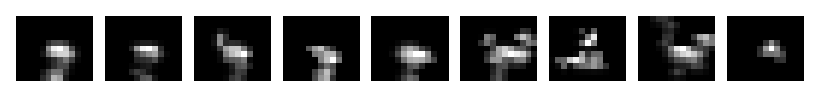

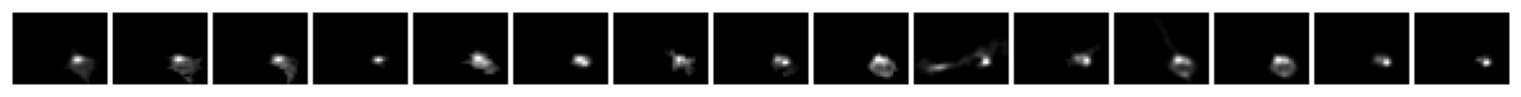

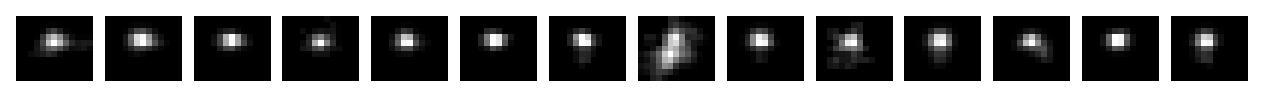

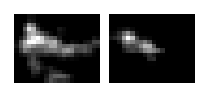

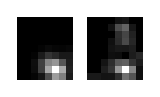

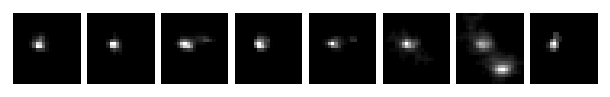

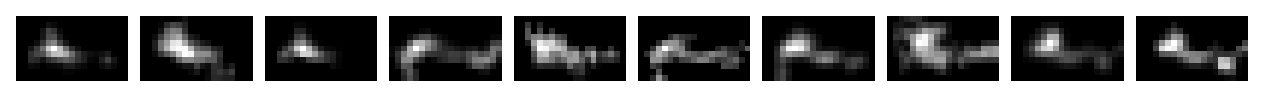

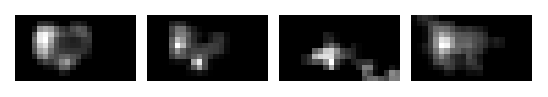

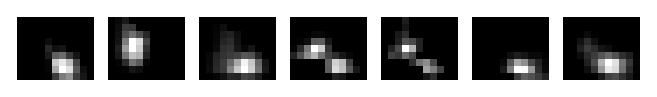

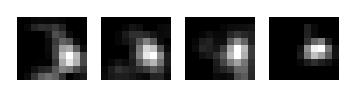

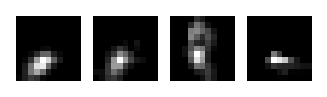

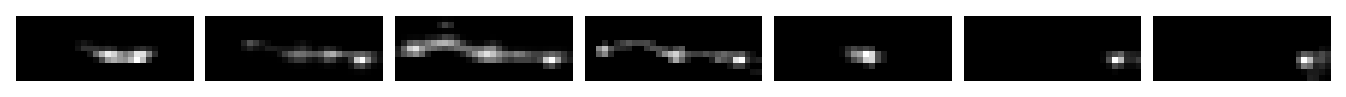

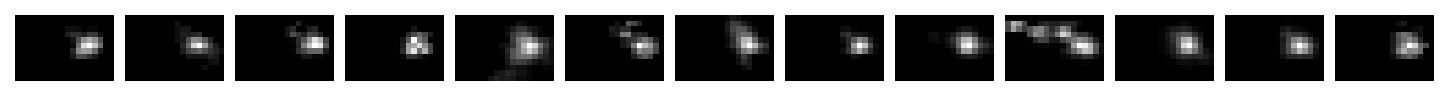

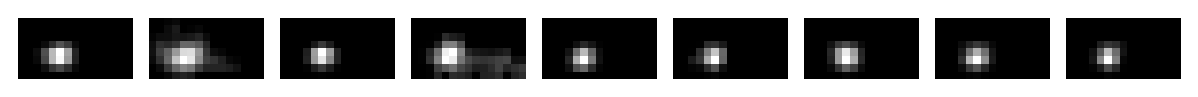

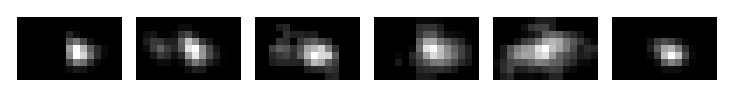

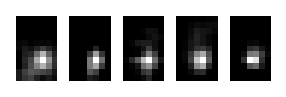

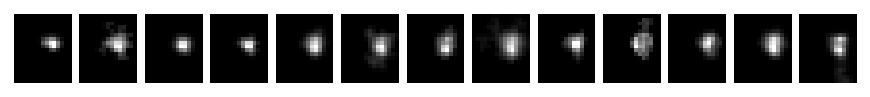

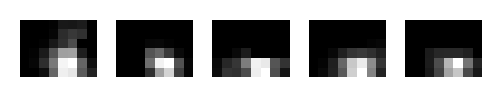

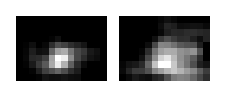

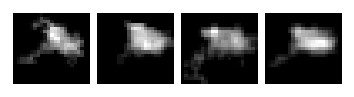

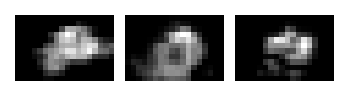

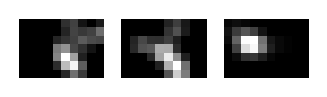

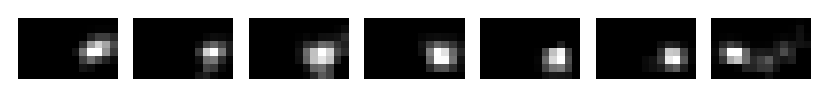

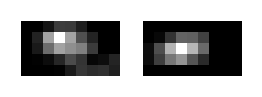

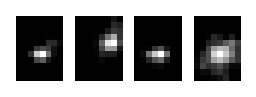

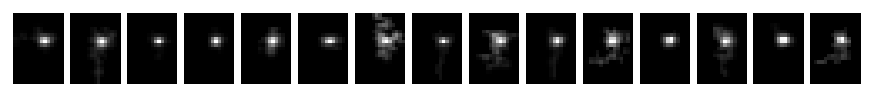

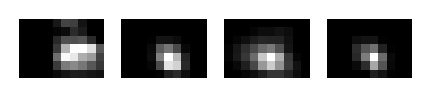

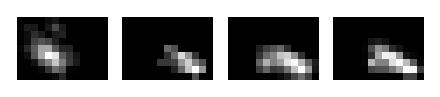

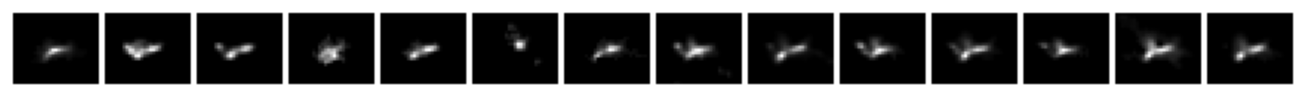

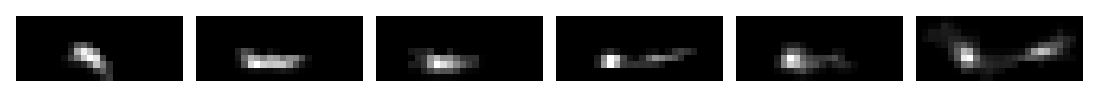

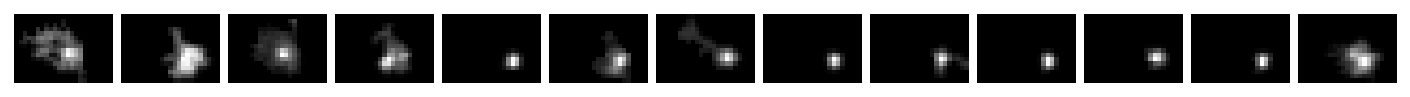

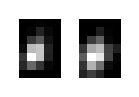

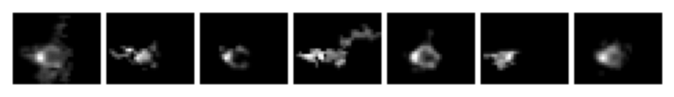

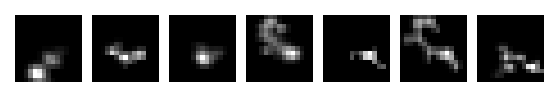

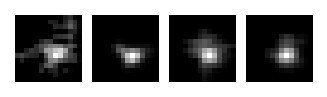

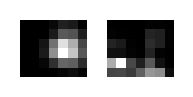

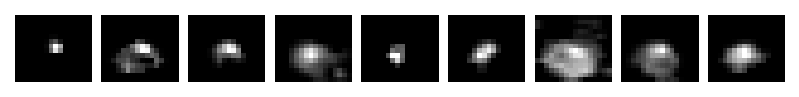

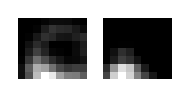

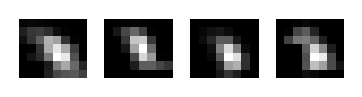

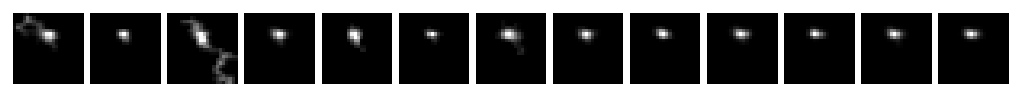

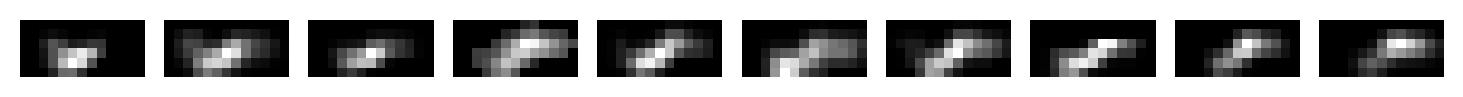

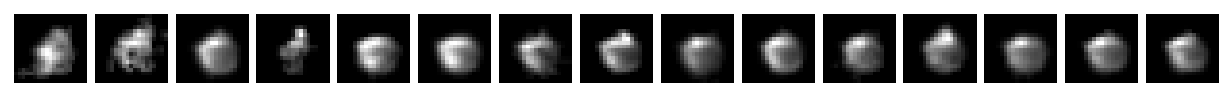

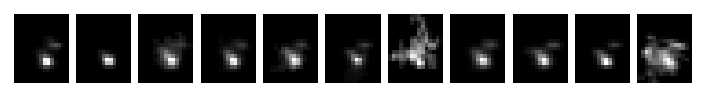

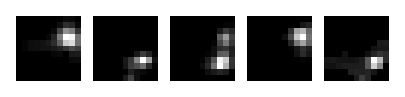

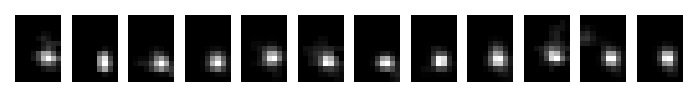

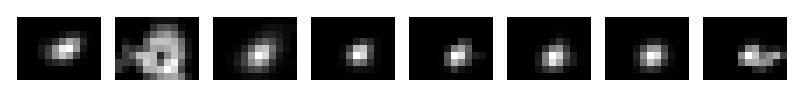

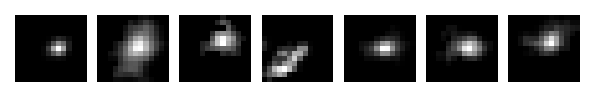

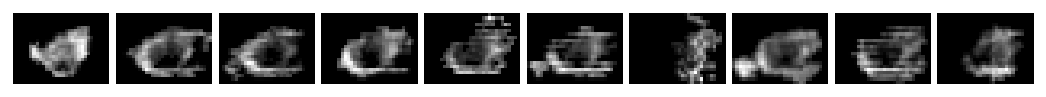

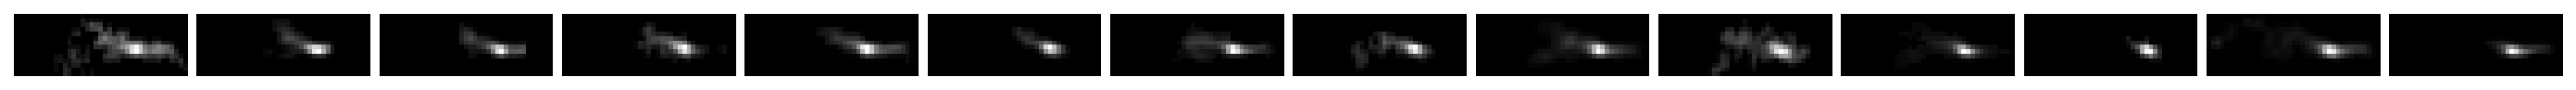

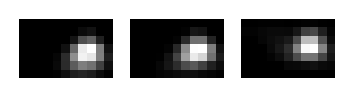

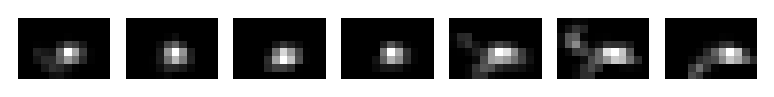

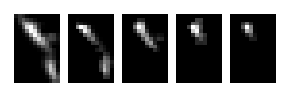

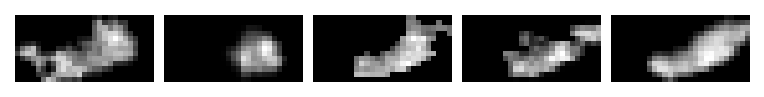

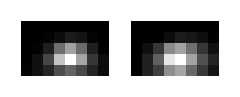

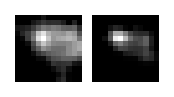

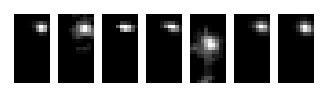

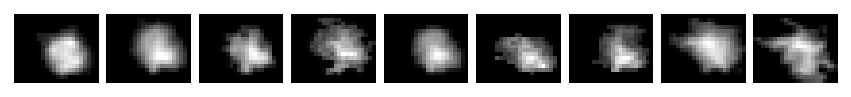

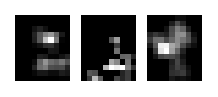

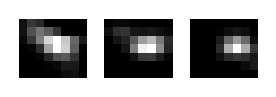

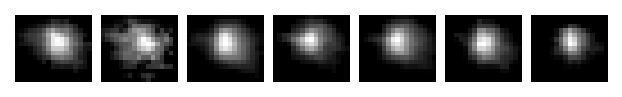

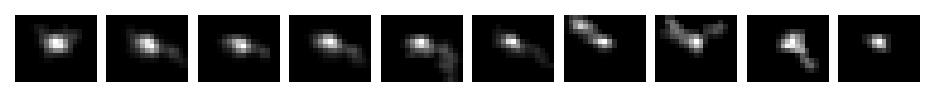

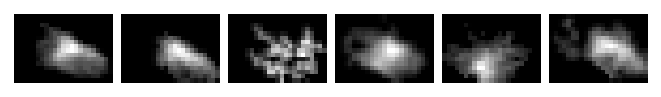

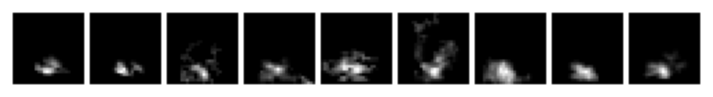

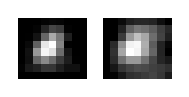

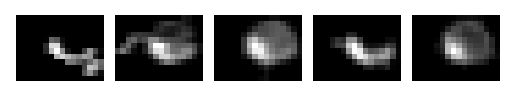

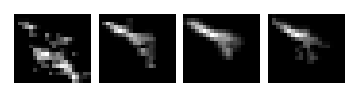

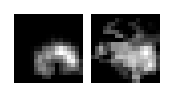

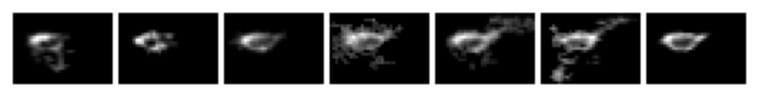

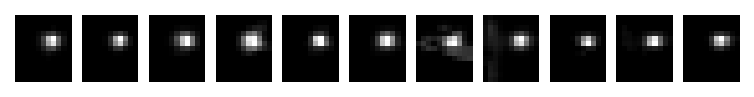

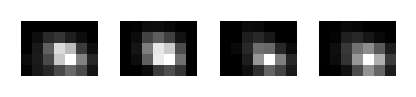

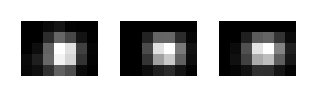

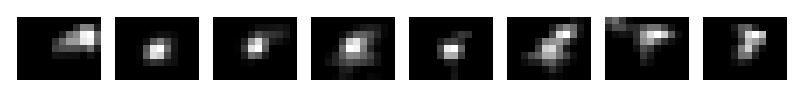

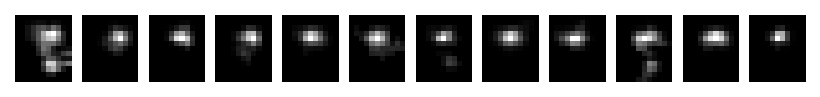

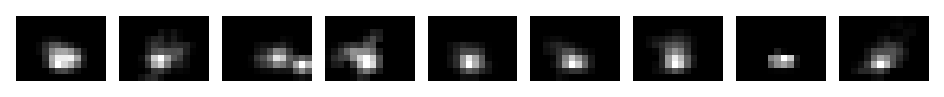

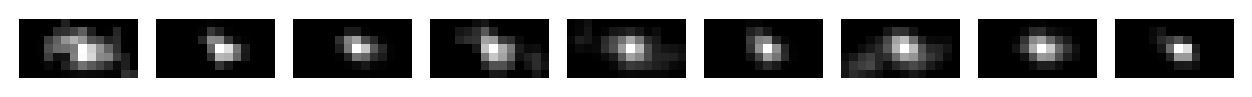

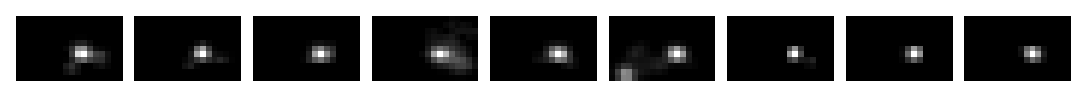

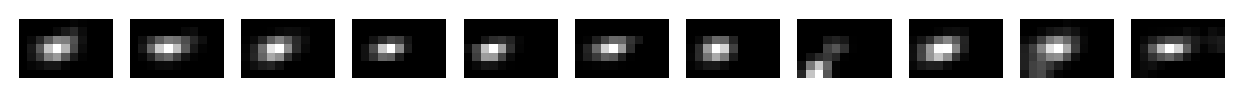

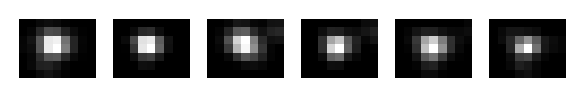

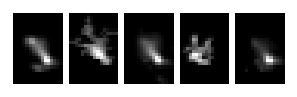

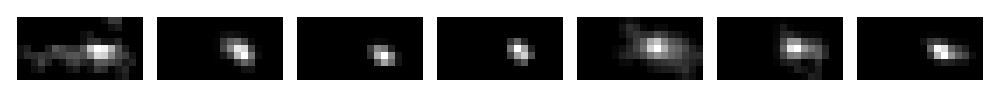

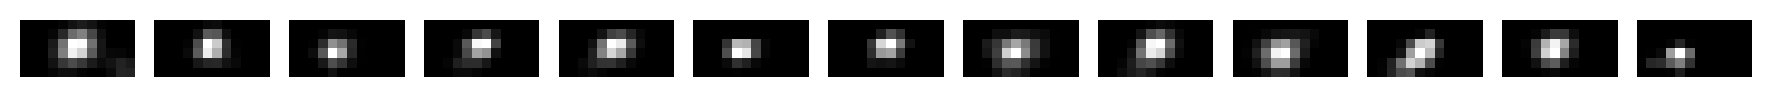

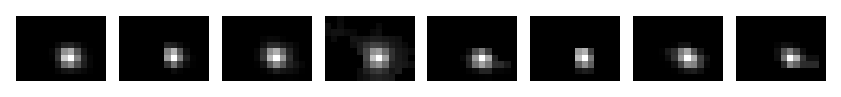

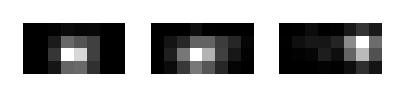

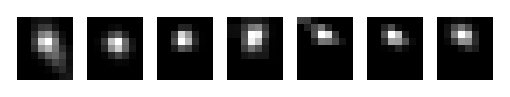

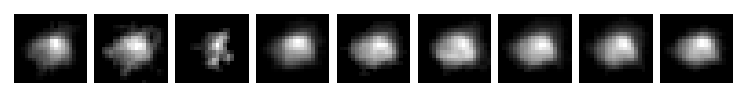

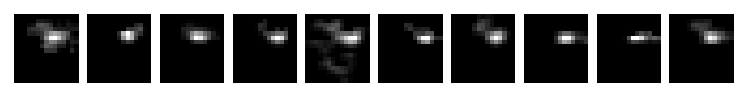

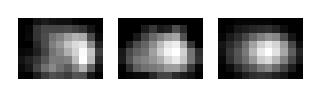

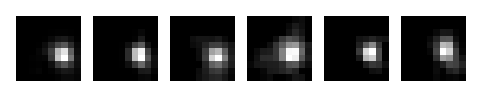

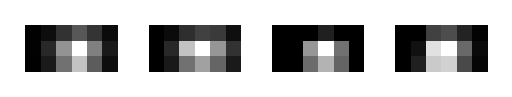

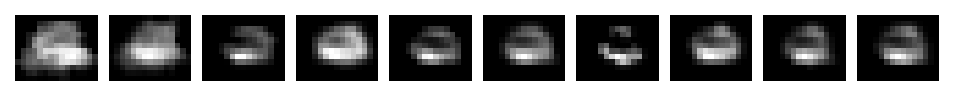

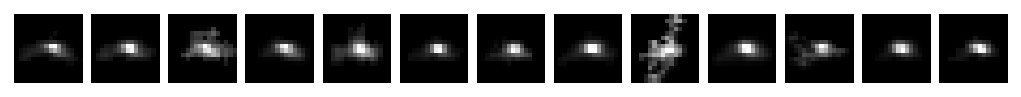

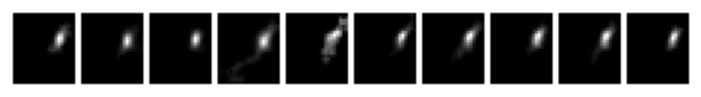

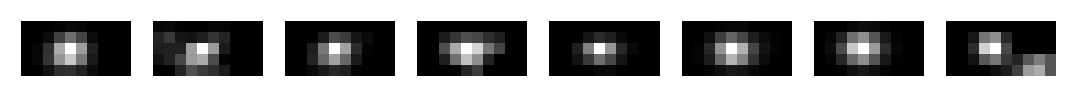

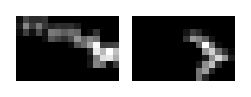

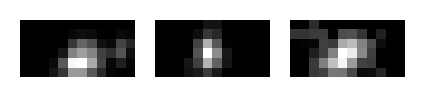

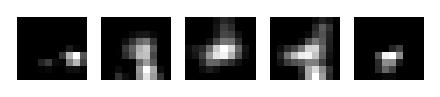

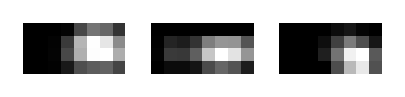

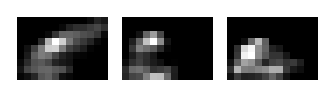

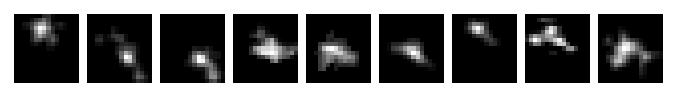

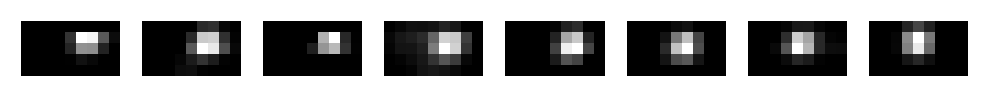

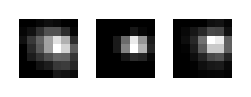

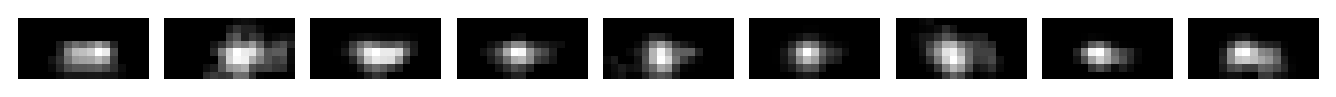

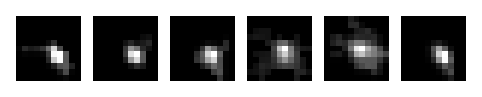

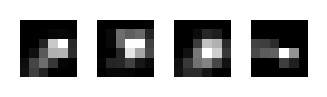

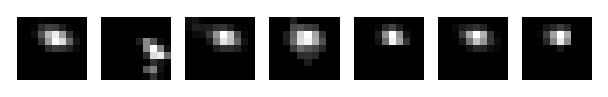

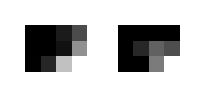

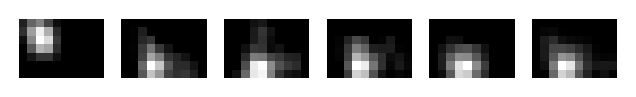

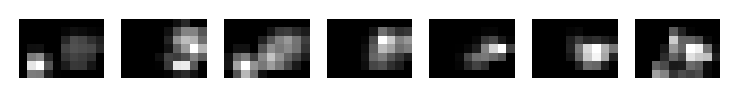

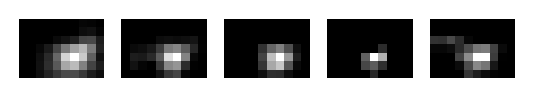

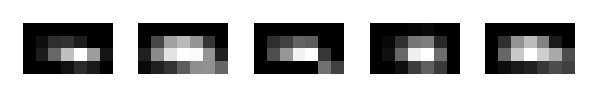

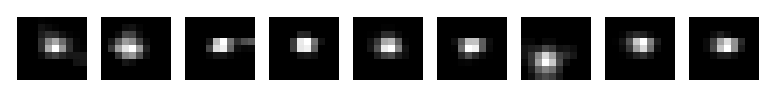

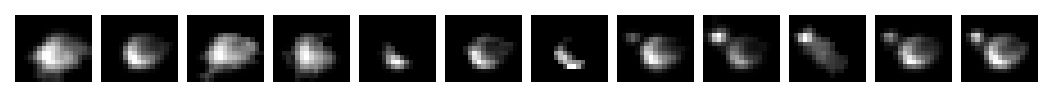

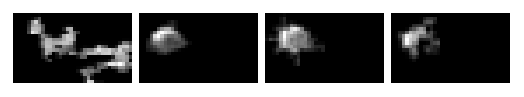

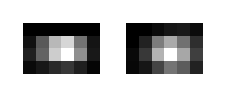

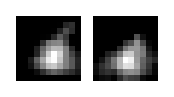

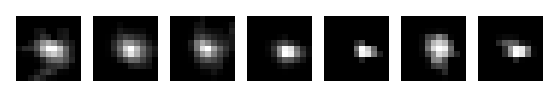

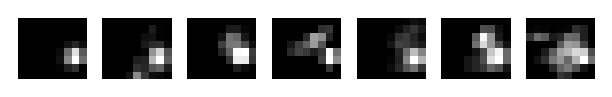

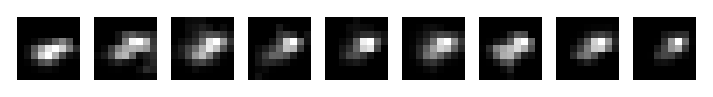

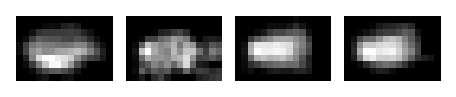

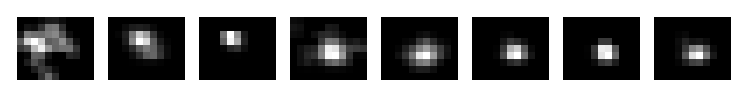

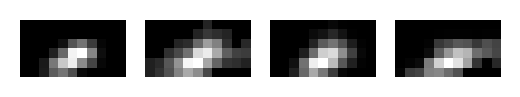

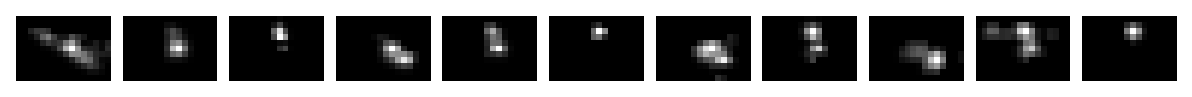

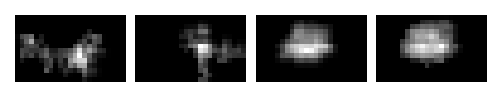

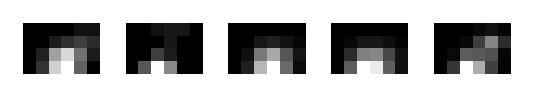

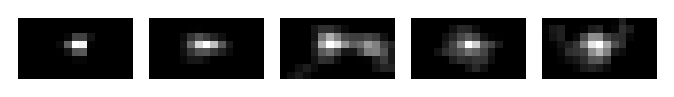

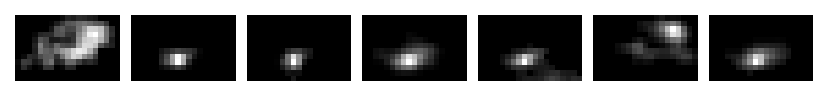

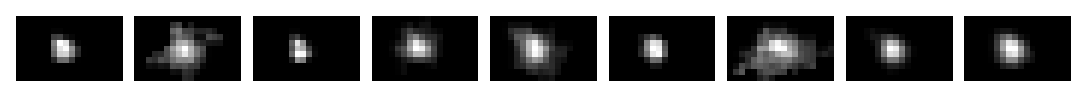

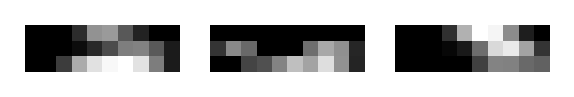

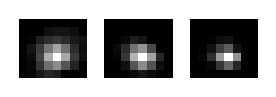

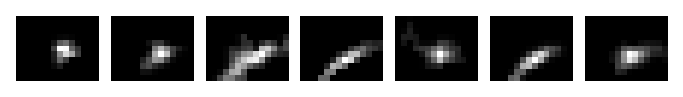

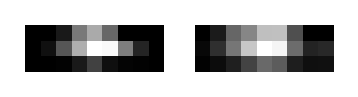

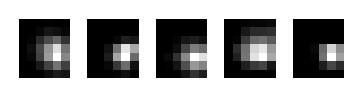

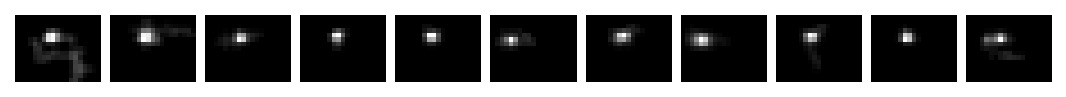

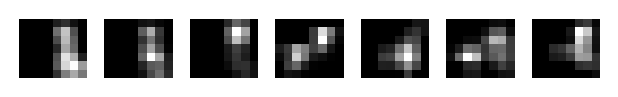

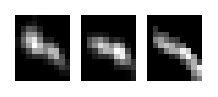

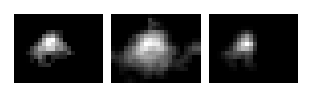

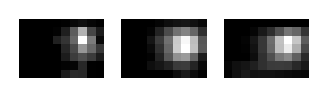

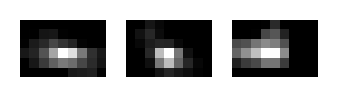

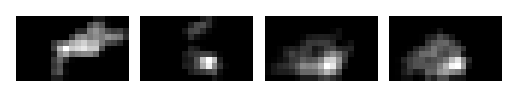

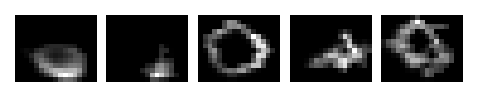

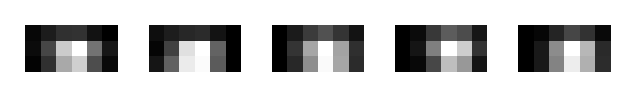

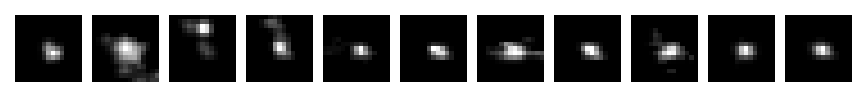

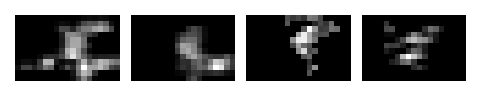

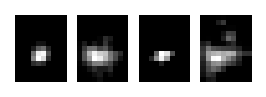

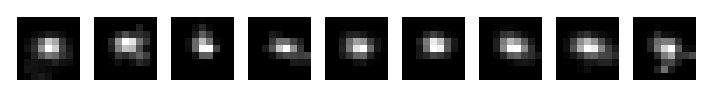

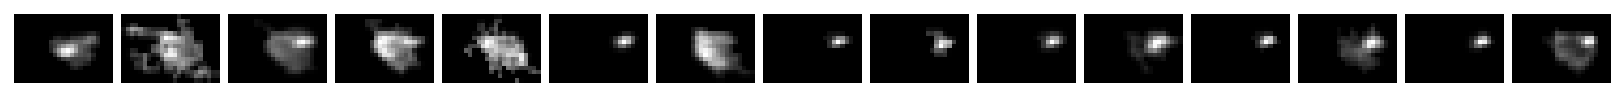

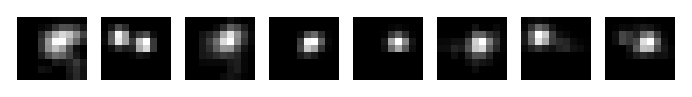

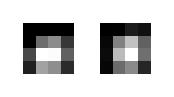

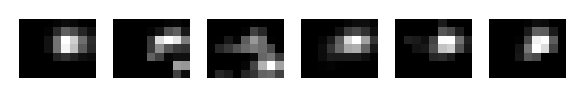

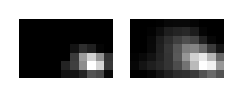

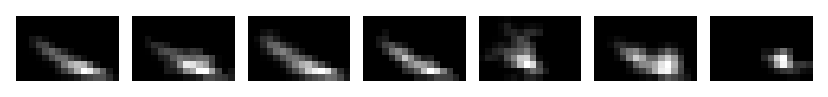

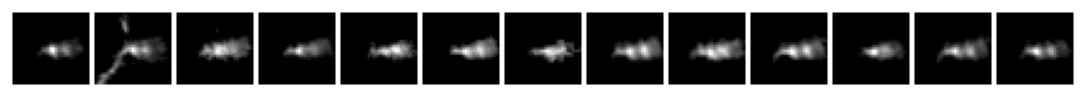

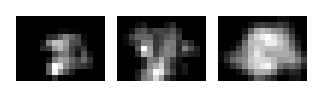

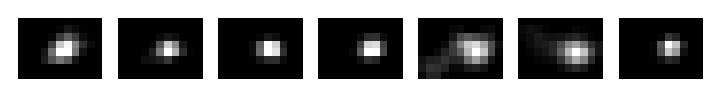

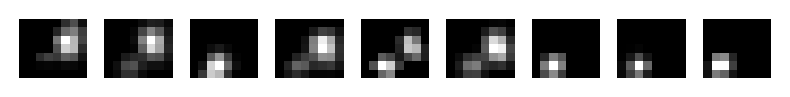

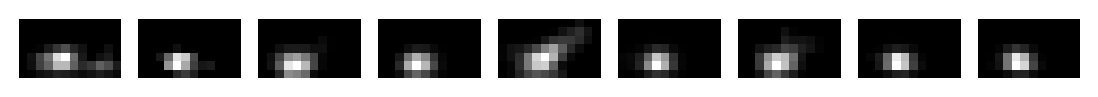

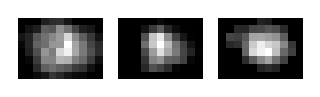

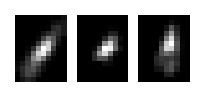

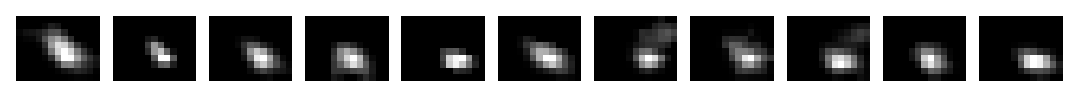

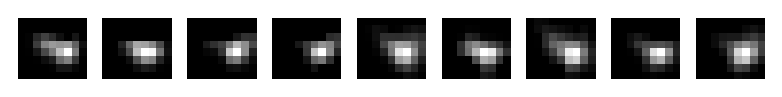

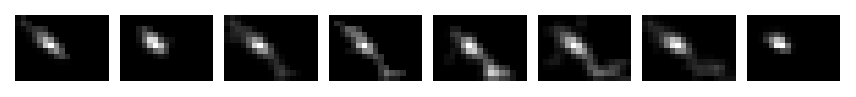

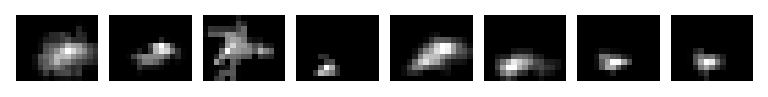

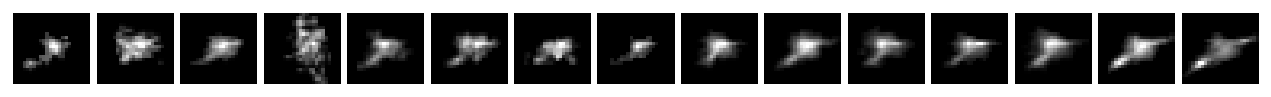

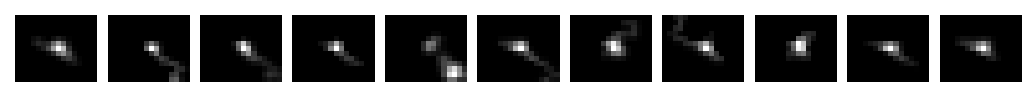

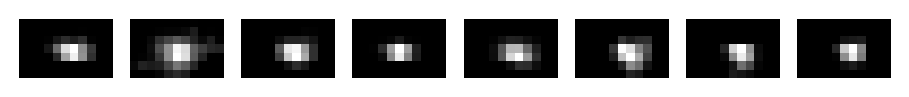

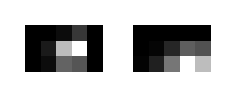

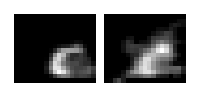

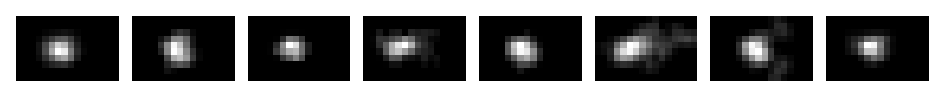

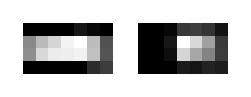

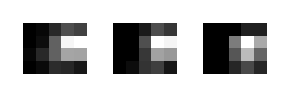

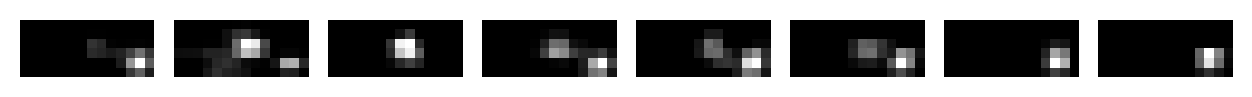

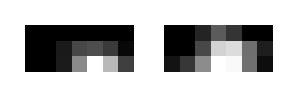

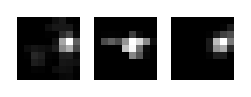

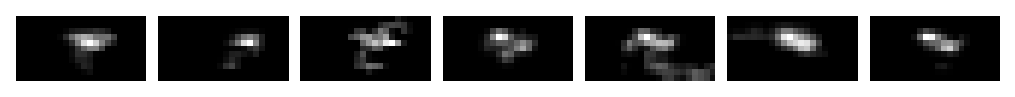

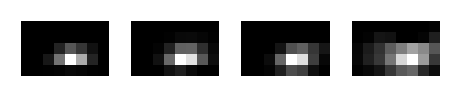

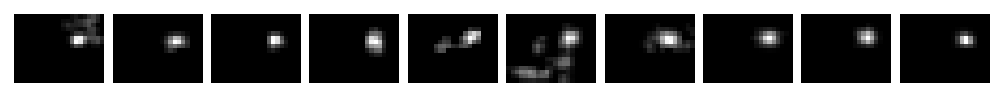

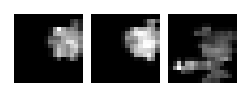

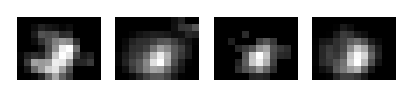

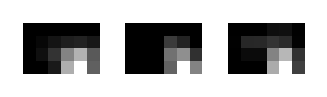

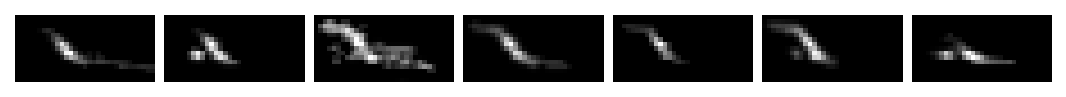

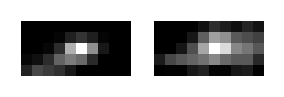

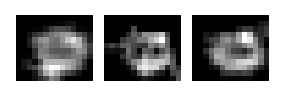

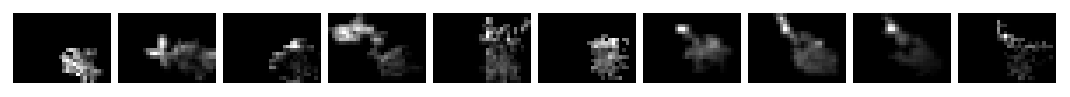

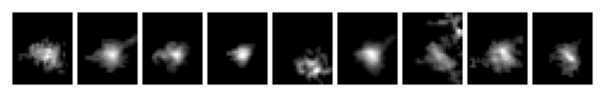

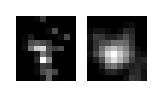

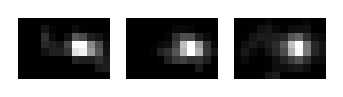

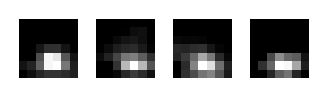

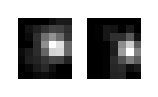

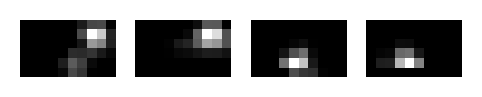

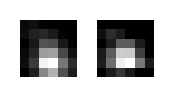

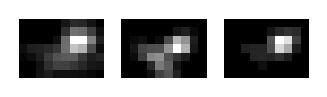

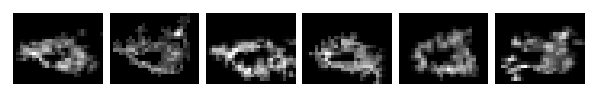

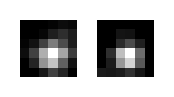

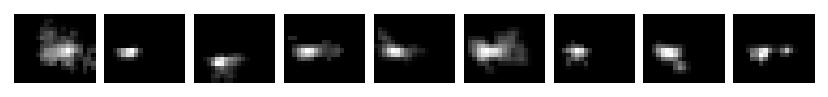

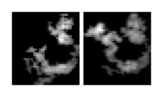

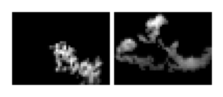

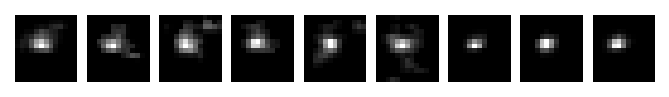

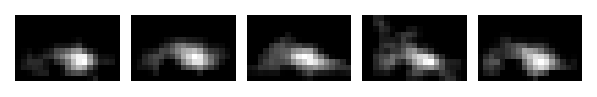

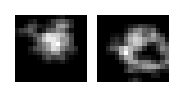

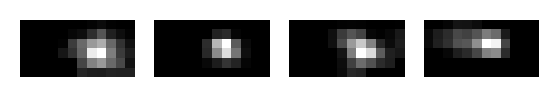

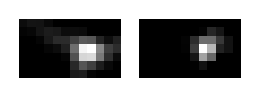

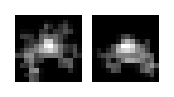

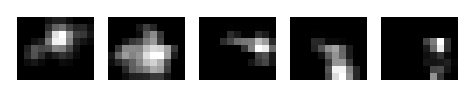

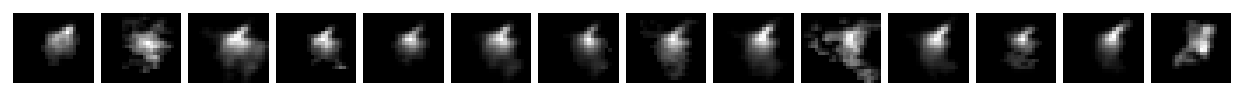

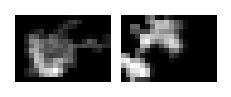

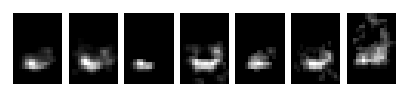

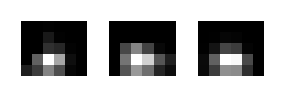

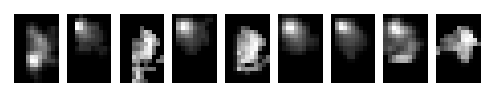

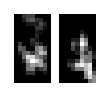

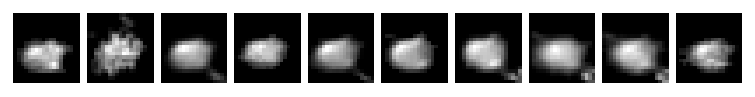

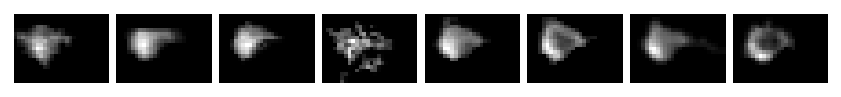

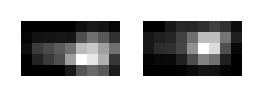

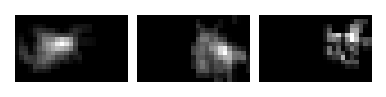

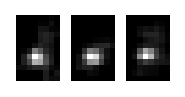

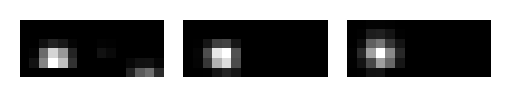

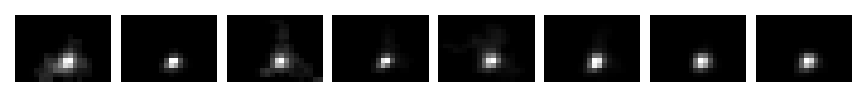

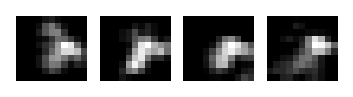

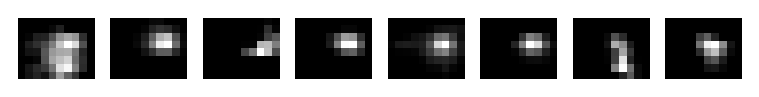

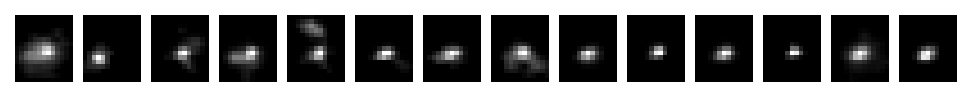

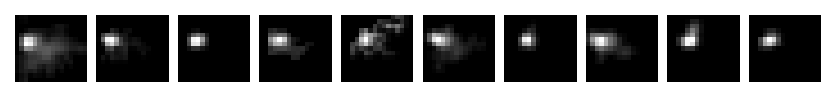

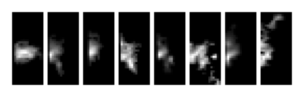

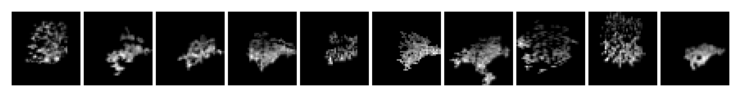

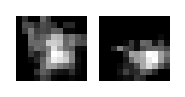

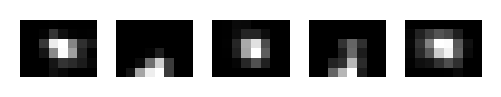

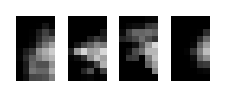

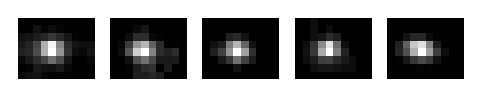

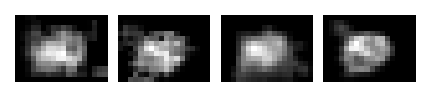

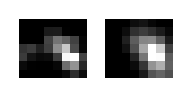

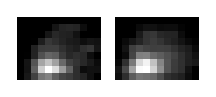

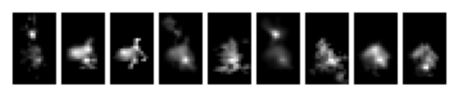

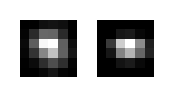

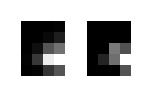

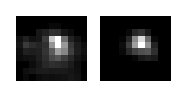

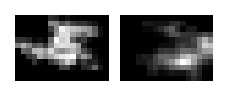

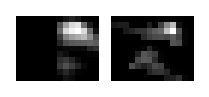

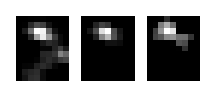

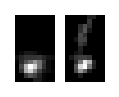

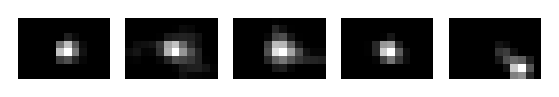

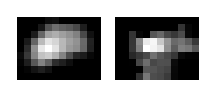

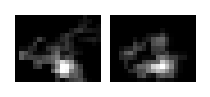

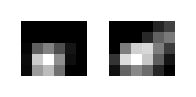

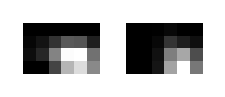

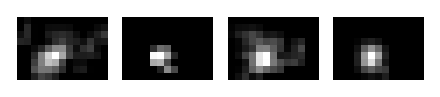

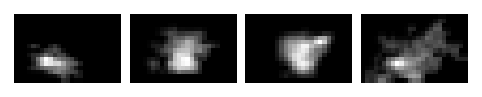

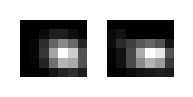

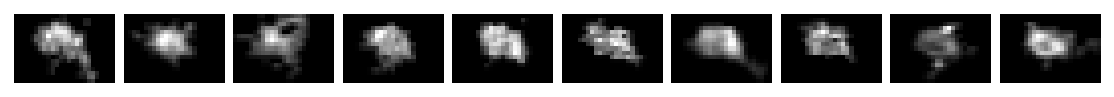

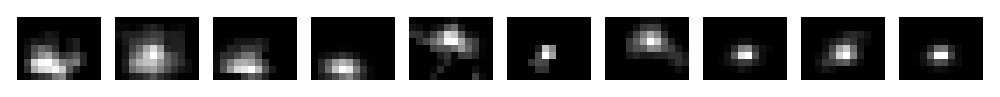

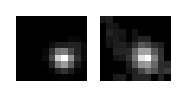

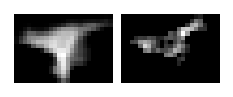

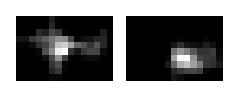

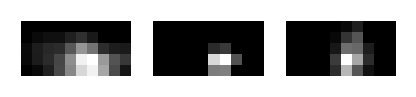

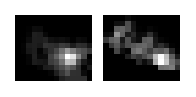

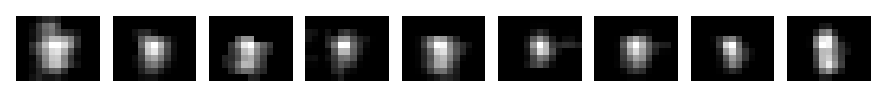

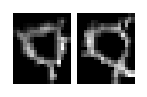

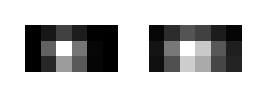

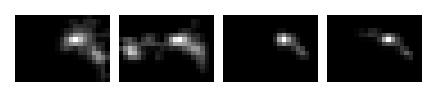

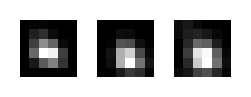

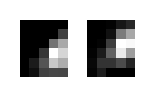

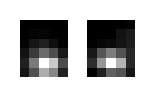

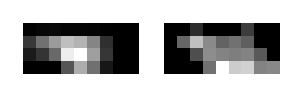

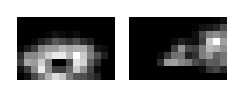

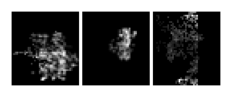

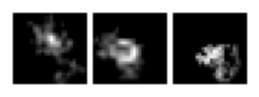

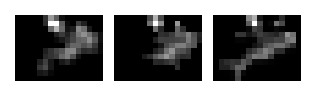

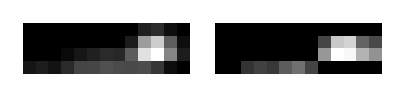

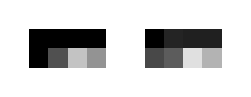

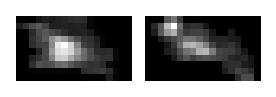

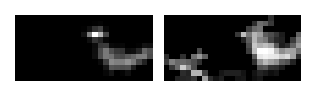

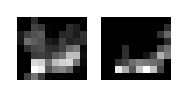

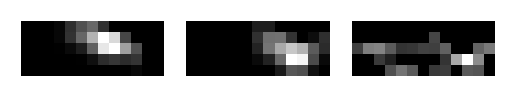

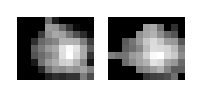

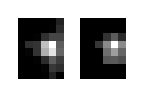

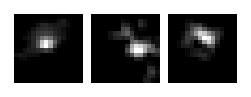

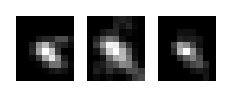

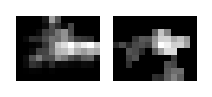

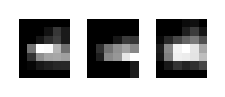

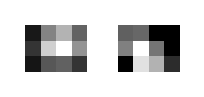

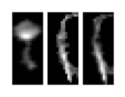

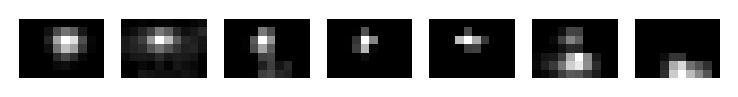

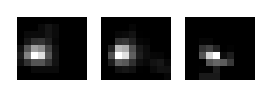

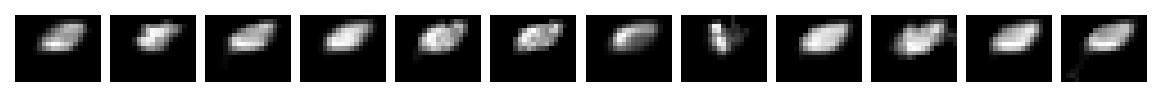

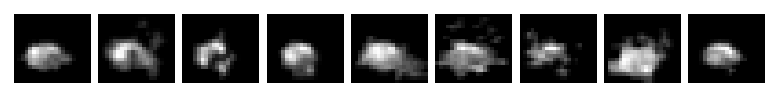

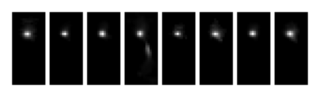

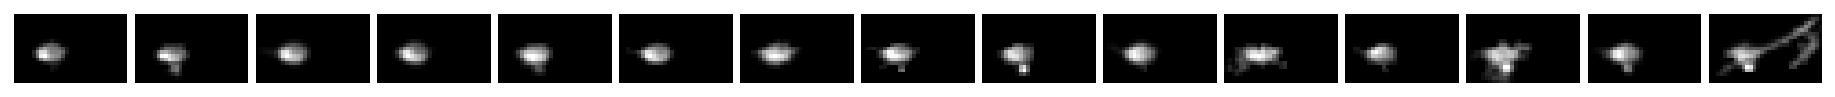

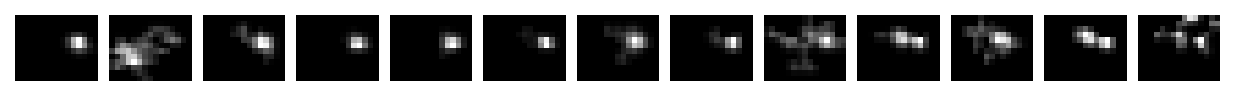

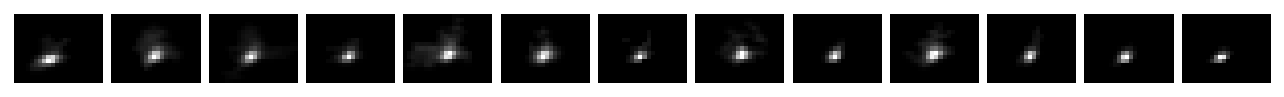

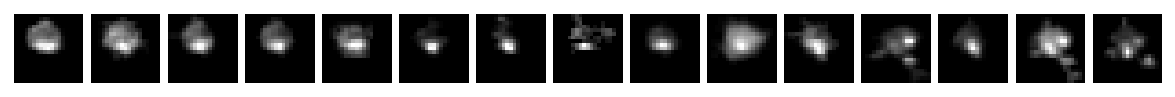

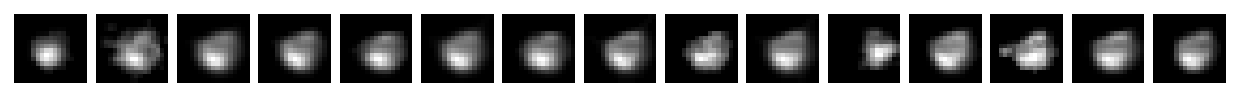

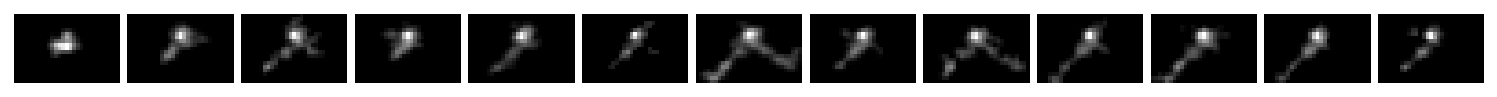

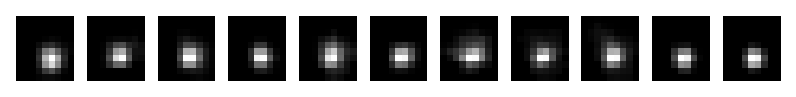

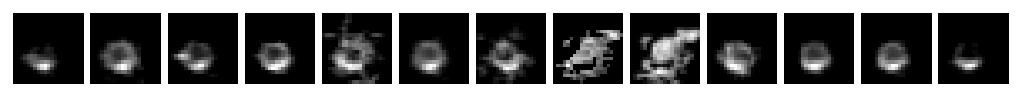

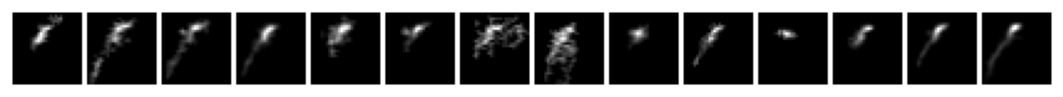

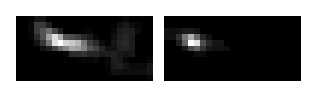

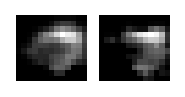

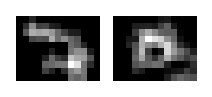

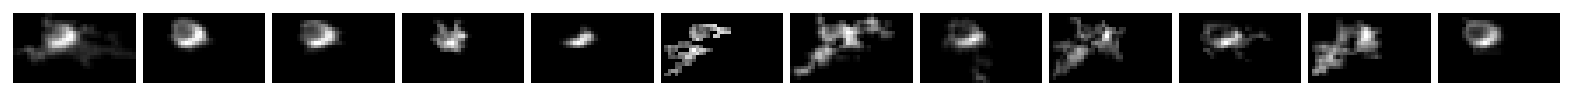

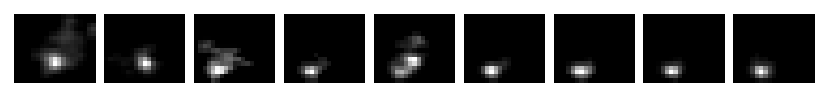

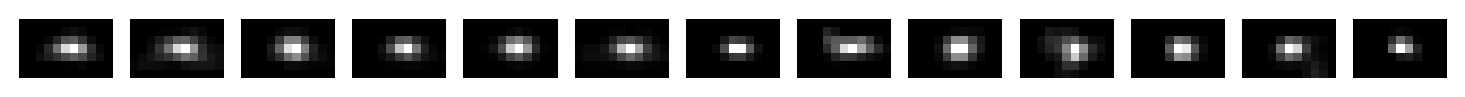

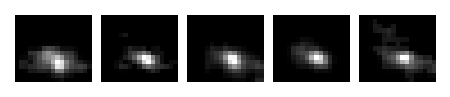

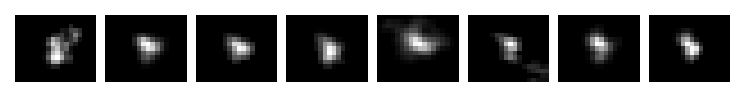

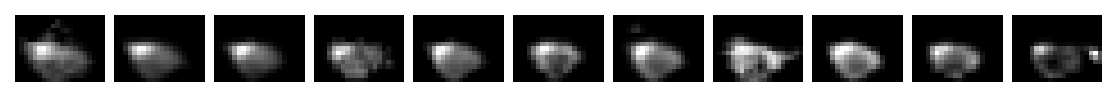

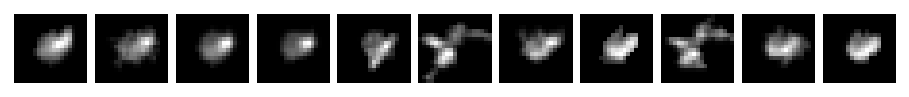

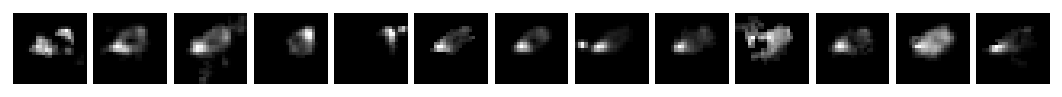

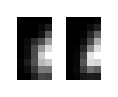

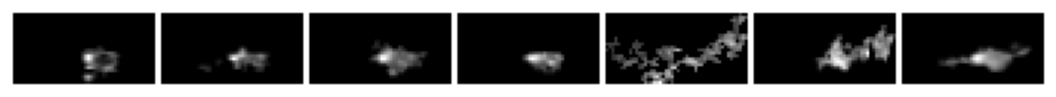

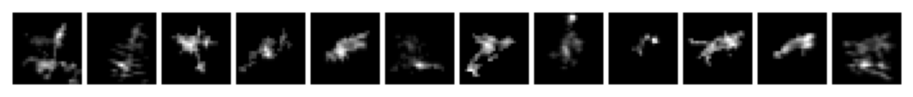

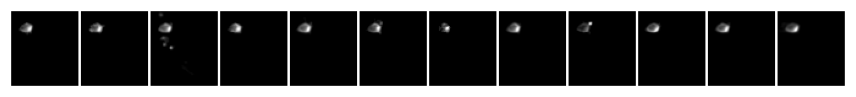

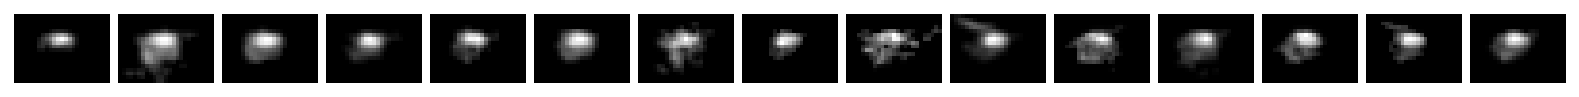

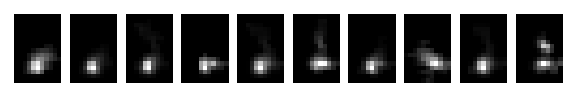

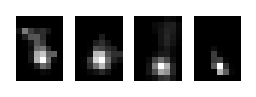

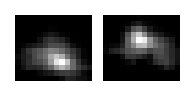

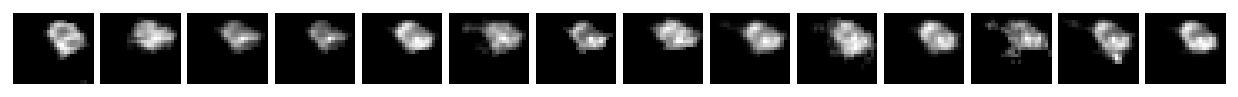

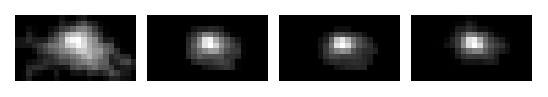

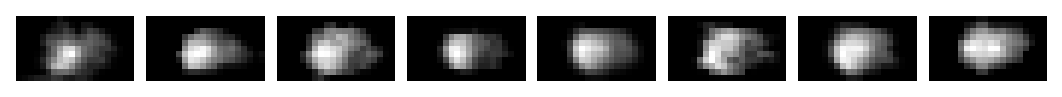

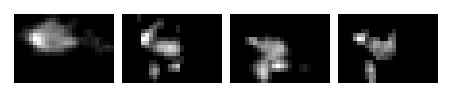

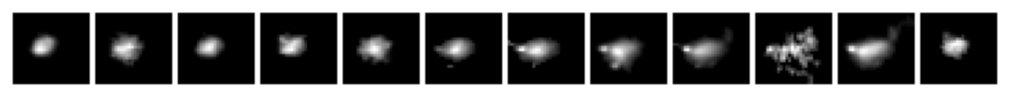

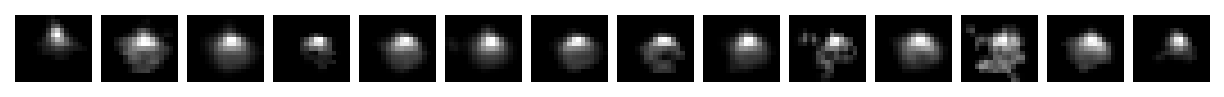

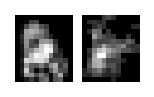

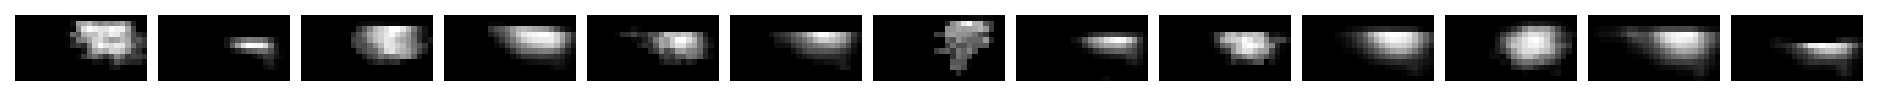

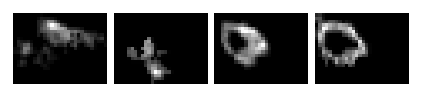

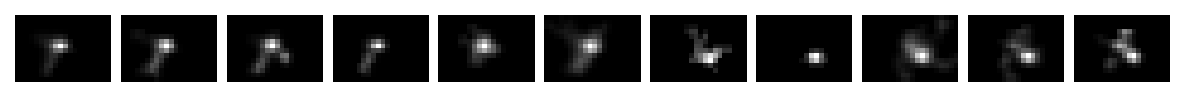

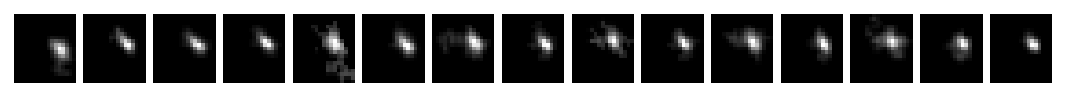

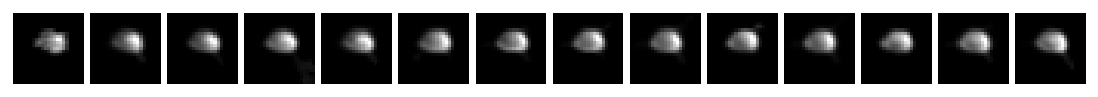

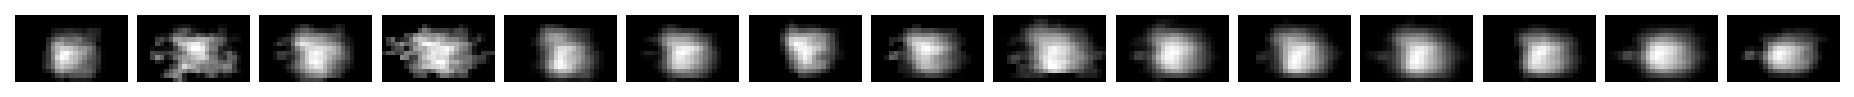

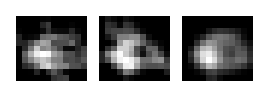

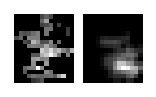

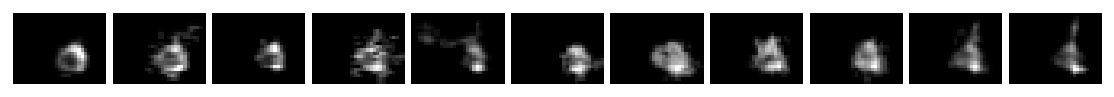

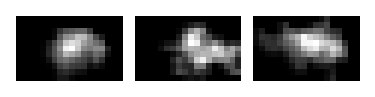

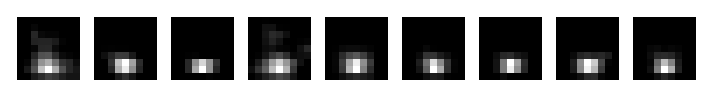

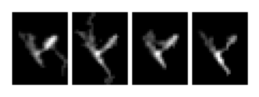

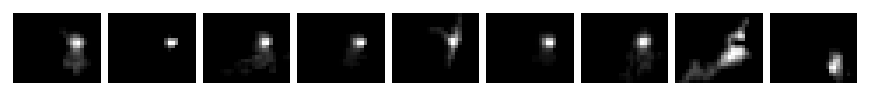

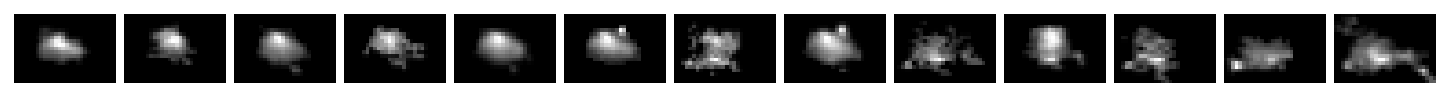

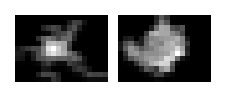

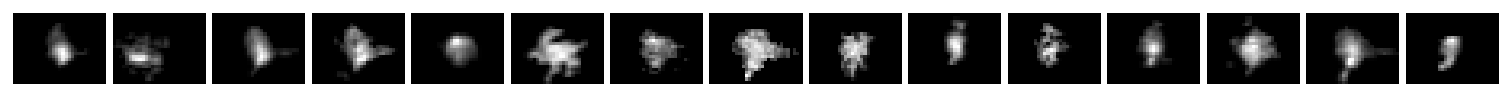

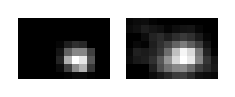

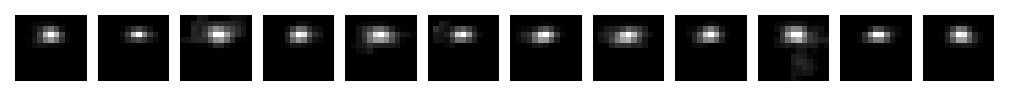

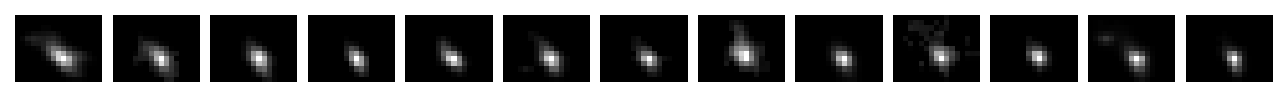

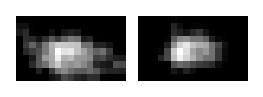

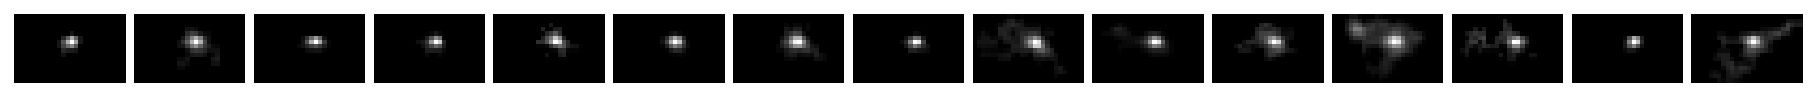

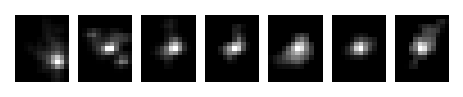

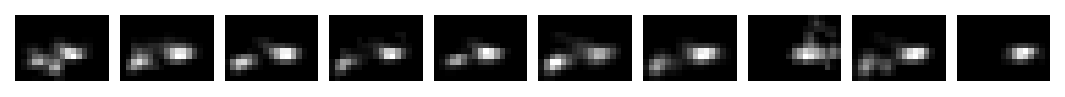

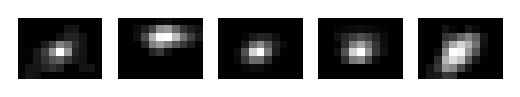

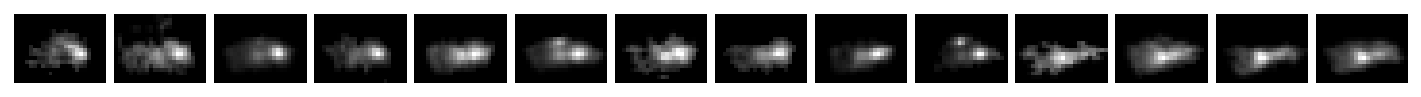

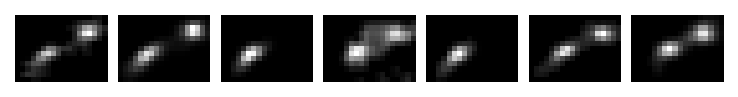

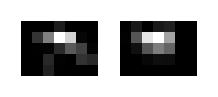

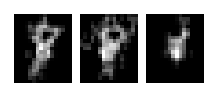

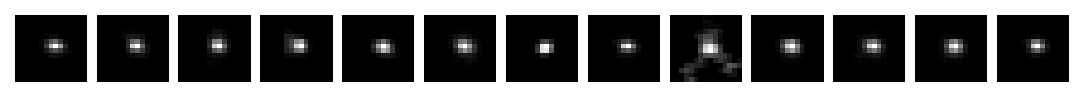

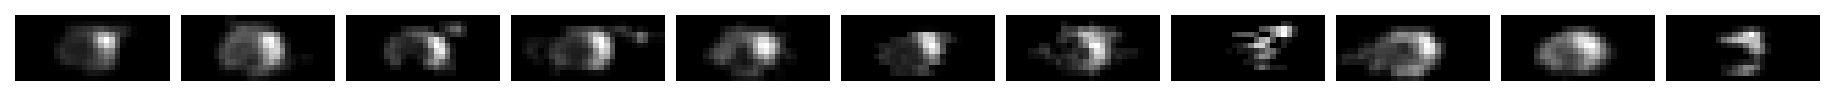

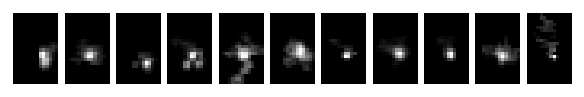

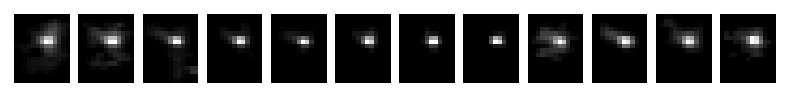

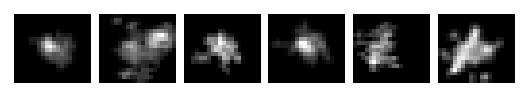

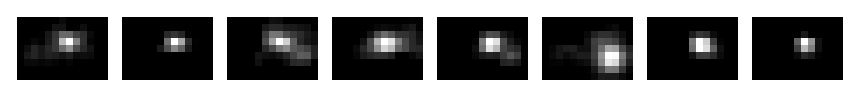

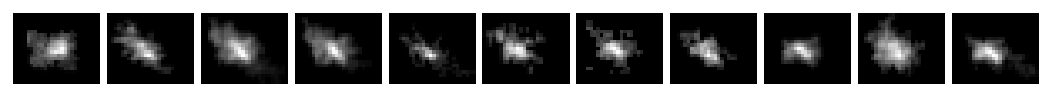

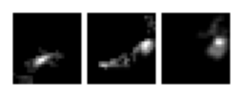

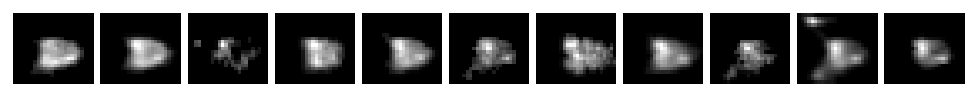

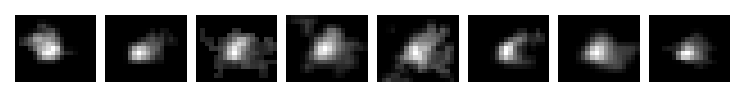

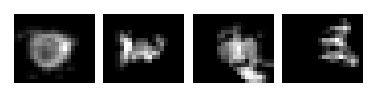

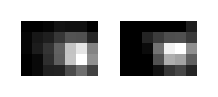

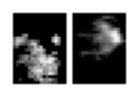

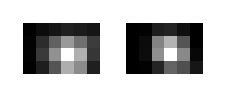

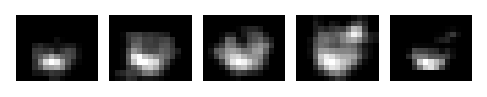

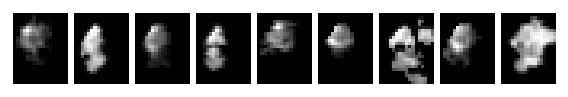

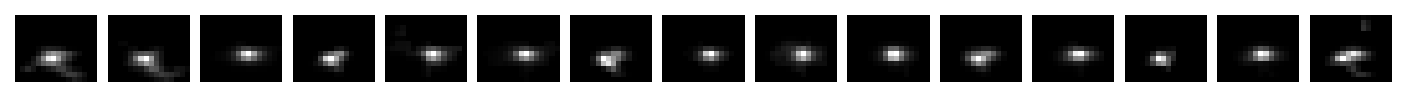

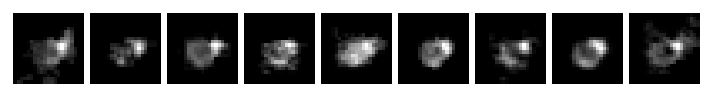

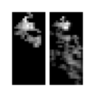

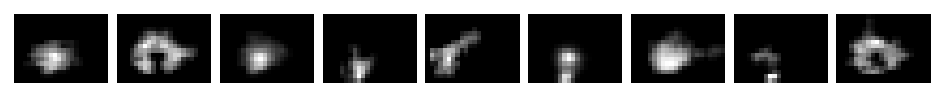

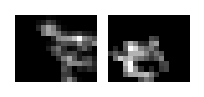

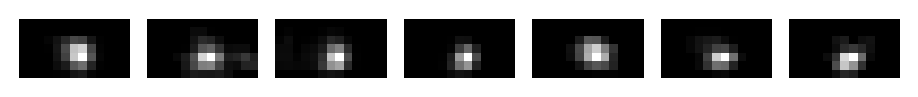

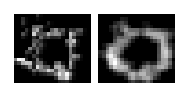

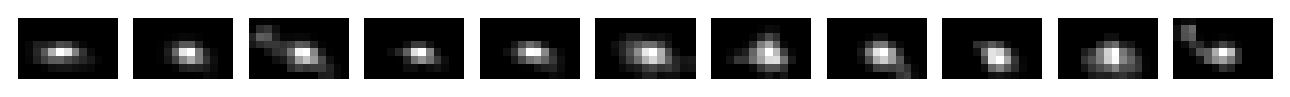

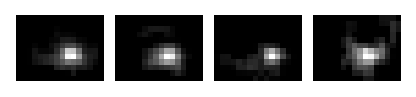

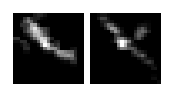

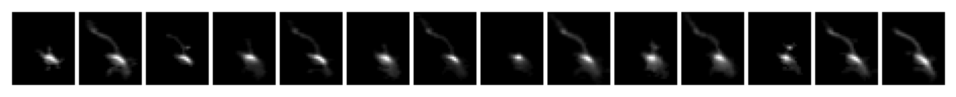

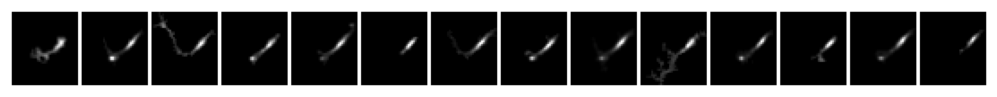

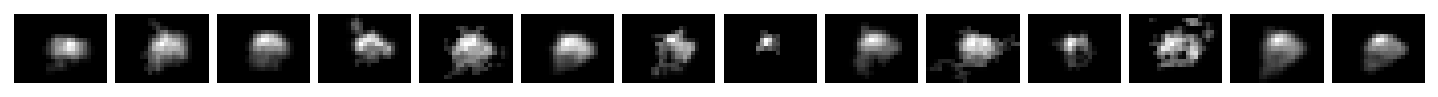

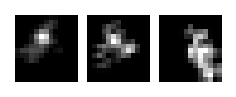

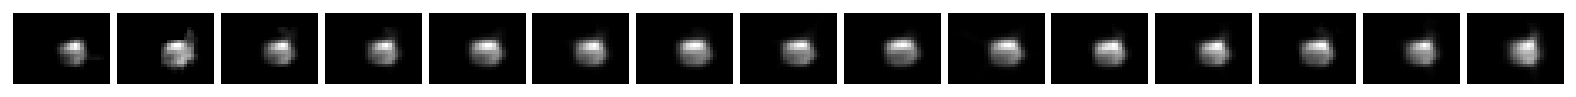

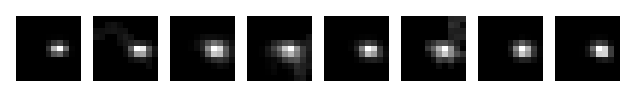

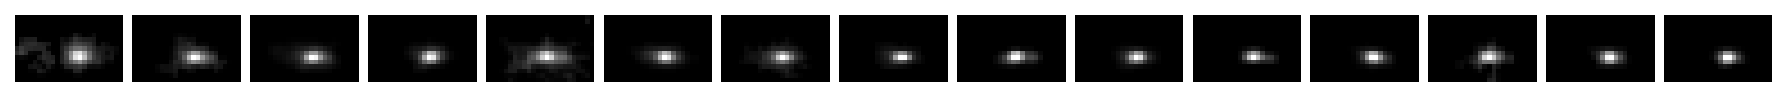

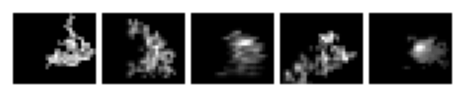

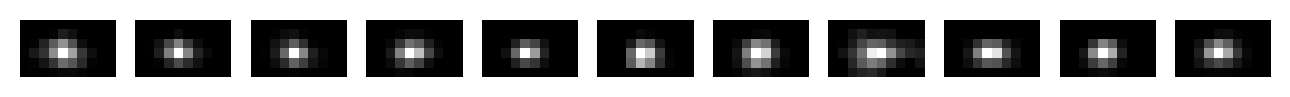

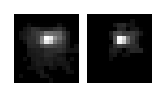

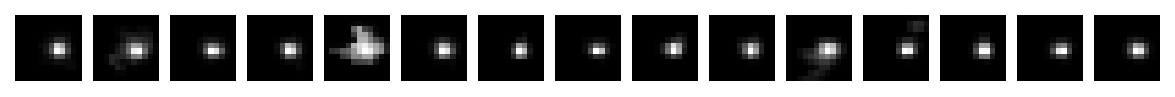

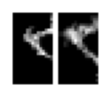

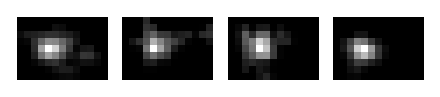

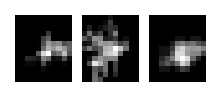

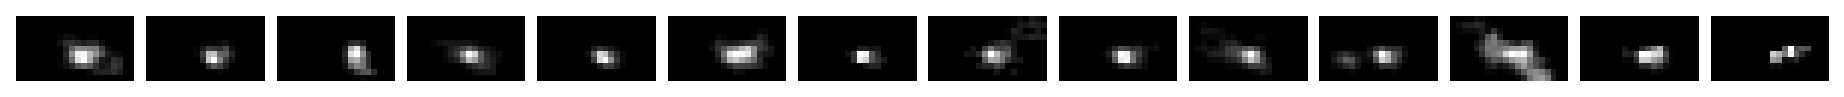

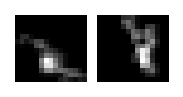

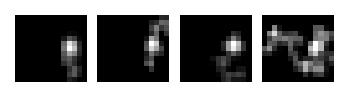

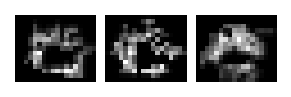

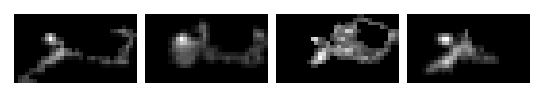

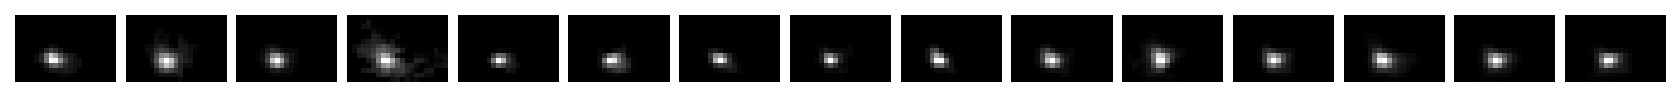

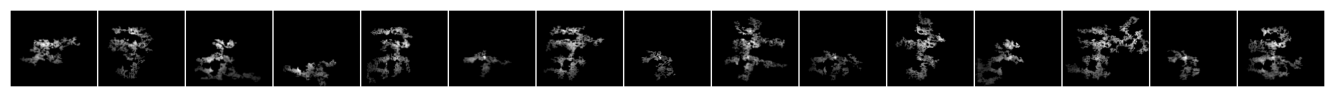

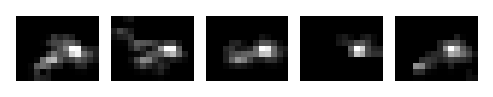

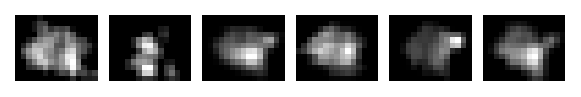

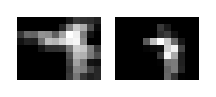

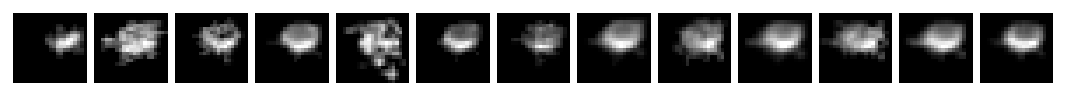

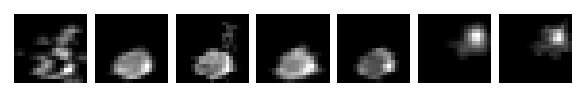

In [48]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:600]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


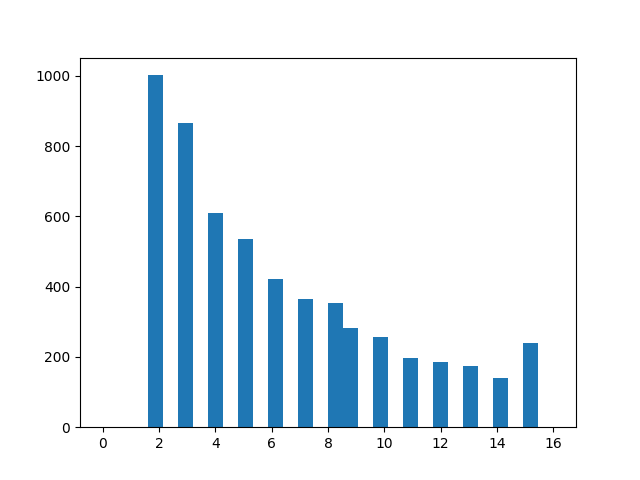

In [49]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [50]:
toc['visualize'] = time.time() - tic

# Save results

In [51]:
# dir_save = Path('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_B').resolve()
dir_save = dir_allOuterFolders
name_save = dir_allOuterFolders.name
# name_save = "mouse_B"
path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

In [52]:
path_save

PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/mouse_g1.ROICaT.results.pkl')

In [53]:
dir_StatFolders

[PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221010/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221011/scanimage_data/post/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221012/scanimage_data/baseline/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221012/scanimage_data/exp/jobNum_0/suite2p/plane0/stat.npy'),
 PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/20221013/scanimage_data/baseline/jobNum_

In [54]:
path_save

PosixPath('/n/data1/hms/neurobio/sabatini/gyu/analysis/suite2p_output/mouse_g1/mouse_g1.ROICaT.results.pkl')

In [55]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
    "Paths": dir_StatFolders
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)

In [56]:
toc['saving'] = time.time() - tic

In [57]:
toc

{'start': 6.866455078125e-05,
 'import_paths': 36.29156827926636,
 'import_data': 261.17526626586914,
 'alignment': 864.9814200401306,
 'blur': 936.9294421672821,
 'NN': 1189.530592918396,
 'SWT': 1191.8879244327545,
 'sim': 1445.9090030193329,
 'separate_diffSame': 1562.3290119171143,
 'clustering': 1742.9859759807587,
 'visualize': 1801.4040982723236,
 'saving': 1802.1700100898743}

In [ ]:
import pickle
with open("/n/data1/hms/neurobio/sabatini/gyu/github_clone/BMI_data/mouse_g1_StatOps/mouse_g1_StatOps.ROICaT.results.pkl", 'rb') as handle:
    saver = pickle.load(handle)

In [ ]:
saver['UCIDs_bySession']

In [ ]:
import scipy.io
scipy.io.savemat("/n/data1/hms/neurobio/sabatini/gyu/github_clone/BMI_data/mouse_g1_StatOps/ROICaT_result.mat", saver)

In [ ]:
import scipy.io

In [ ]:
test = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044_manually_aligned.mat', simplify_cells=True)

In [ ]:
test['this_mouse']['ud']['sismat']

In [ ]:
sismat = test['this_mouse']['ud']['sismat']

In [ ]:
ucid_gt = [np.ones(data.n_roi[ii])*-1 for ii in range(data.n_sessions)]

for sesh in range(sismat.shape[1]):
    for ii in range(sismat.shape[0]):
        idx = sismat[:,sesh][ii] -1
        if np.isnan(idx) == False:
#             print(sesh, idx, ii)
            ucid_gt[sesh][int(idx)] = ii

In [ ]:
_, counts = np.unique(np.concatenate(ucid_gt), return_counts=True)

In [ ]:
plt.figure()
plt.hist(counts, 30, range=(2, data.n_sessions+1));

In [ ]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=np.concatenate(ucid_gt),
    confidence=None,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)